# Projet : Inpainting et algorithme du LASSO

                                                                         Valentyn G.
                                                                         Léane S.
                                                        
(c) Images : tous droits réservés

In [1]:
#/////////////////////////////////////////////////////////////////////////////////////////////////// <imports nécessaires> ////

from arftools import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import rgb_to_hsv 
from matplotlib.colors import hsv_to_rgb
from matplotlib import cm
from matplotlib import gridspec
import time

import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#////////////////////////////////////////////////////////////////////////////////////////////////// </imports nécessaires> ////

## 1. Préambule : régression linéaire, régression Ridge et LASSO

Le phénomène de _surapprentissage_ se produit lorsqu'un paramétrage est très précisément adapté à un ensemble de données particulier, et ne peut pas être exporté pour généraliser le modèle. Les _régularisations Ridge et LASSO_ sont des techniques simples qui permettent de réduire la complexité du modèle ; elles empêchent le surapprentissage qui peut résulter d'une simple régression linéaire.  

Ridge et LASSO imposent en fait une contrainte sur les coefficients w, les poids trouvés par la régression. La régression _Ridge_ effectue la régularisation L2, c'est-à-dire qu'elle ajoute une pénalité équivalente au carré de la norme L2 du vecteur w. La régression _LASSO_ effectue la régularisation L1, c'est-à-dire qu'elle ajoute une pénalité équivalente à la valeur de la norme L1 du vecteur w.  
L'importance de cette pénalité est régulée par un paramètre $\alpha$.

In [2]:
#/////////////////////////////////////////////////////////////////////////////////////// <erreurs adaptées ridge et lasso> ////

# Cette fonction sera executée avant chaque appel des fonctions suivantes. On l'a déjà utilisée avec le TME 3.
def do_shape(fonc):
    # Assure les dimensions des données d'entrée: X(n,d); W(1,d); Y(n,1).
    def shape(datax,datay,w,*args,**kwargs):
        datax,datay,w = datax.reshape(len(datay),-1),datay.reshape(-1,1),w.reshape((1,-1))
        return fonc(datax,datay,w,*args,**kwargs)
    return shape

# Régression linéaire ///////////////////////////////////////////////////////////////////////
@do_shape
def mse(dataX,dataY,w,alpha=1): # alpha paramètre fantôme
    # Moyenne de l'erreur aux moindres carrés. 
    return np.mean((dataY-np.dot(dataX,w.T))**2)
@do_shape
def mseG(dataX,dataY,w,alpha=1): # alpha paramètre fantôme
    # Gradient moyen de ladite erreur.
    return np.mean(-2*dataX*(dataY-np.dot(dataX,w.T)),axis=0)

# Régression Ridge (régularisation de Tikhonov) //////////////////////////////////////////////
@do_shape
def ridge(datax,datay,w,alpha=1):
    # Erreur aux moindres carrés, avec pénalité équivalente au carré de la norme L2 des poids.
    # Remarquons l'absence de la racine carrée.
    return mse(datax,datay,w) + alpha*np.sum(w**2) 
@do_shape
def ridgeG(datax,datay,w,alpha=1):
    # Gradient de l'erreur Ridge.
    return mseG(datax,datay,w) + 2*alpha*w 

# Régression Lasso (algorithme du LASSO) ////////////////////////////////////////////////////
@do_shape
def lasso(datax,datay,w,alpha=1):
    # Erreur aux moindres carrés, avec pénalité équivalente à la norme L1 des poids.
    return mse(datax,datay,w) + alpha*np.sum(np.abs(w))
@do_shape
def lassoG(datax,datay,w,alpha=1):
    # Gradient de l'erreur Lasso.
    return mseG(datax,datay,w) + alpha*np.sign(w)

#////////////////////////////////////////////////////////////////////////////////////// </erreurs adaptées ridge et lasso> ////

In [3]:
#///////////////////////////////////////////////////////////////////////////////////////////////////// <objet classifieur> ////

# ··· De quoi implémenter la régression linéaire, les régressions Ridge et Lasso.
   
class Lineaire(object):
    def __init__(self,regularization=None,max_iter=1000,eps=0.01,alpha=0):
        # :reg: type de régularisation entre L1 (Lasso), L2 (Ridge) ou rien (régression linéaire)
        self.reg = regularization
        if self.reg == None:
            # :loss: fonction de coût et son gradient :loss_g:
            self.loss, self.loss_g = mse, mseG
        elif self.reg == 'ridge':
            self.loss, self.loss_g = ridge, ridgeG
        elif self.reg == 'lasso':
            self.loss, self.loss_g = lasso, lassoG
        # :max_iter: nombre d'itérations, de pas :eps: (learning rate).
        self.max_iter, self.eps = max_iter,eps
        # :alpha: le paramètre de régularisation
        self.alpha = alpha
        # allossA et allossT servent à visualiser l'évolution de l'erreur au fil des itérations.
        self.allossA, self.allossT = [], []

    def fit(self,dataX,dataY,testX=False,testY=False,init="random"):
        # :testX:, :testY:, données et labels de test.
        # :dataX:, :dataY:, données et labels de train.
        # :init: type d'initialisation du vecteur des poids w
        # Transformation de dataY en vecteur colonne.
        dataY = dataY.reshape(-1,1)
        N = len(dataY)
        dataX = dataX.reshape(N,-1)
        D = dataX.shape[1]
        # Initialisation des poids à donner à chaque dimension, 
        # selon le paramètre init. En garder une copie pour faire un historique.
        if init == "random": 
            self.w = np.random.random((1,D))
        elif init == "mean": 
            self.w = np.mean(dataX,axis=0).reshape(1,-1) # de shape (1,D)
        self.allw = np.array([self.w.reshape(-1)])
        # Lancer la régression.
        # Itérer jusqu'au butoir,
        for i in range(self.max_iter):
            # en gardant à chaque fois une trace de l'erreur sur train et test,
            if type(testX) != bool:
                self.allossA.append(self.loss(dataX, dataY, self.w, self.alpha))
                self.allossT.append(self.loss(testX, testY, self.w, self.alpha))
            # et en rafraîchissant les poids courants et l'historique global.
            # La syntaxe pour les trois possibilités, régression linéaire, Ridge et Lasso,
            # est en fait la même.
            self.w -= self.eps * self.loss_g(dataX, dataY, self.w, self.alpha)
            # Ajouter les nouveaux poids à l'historique.
            self.allw = np.append(self.allw,self.w,axis=0)
        return self.w

    def predict(self,dataX):
        # Une fois les poids calculés, les utiliser pour la prédiction.
        if len(dataX.shape)==1:
            dataX = dataX.reshape(1,-1)
        return np.sign(np.dot(dataX,self.w.T)).reshape(-1)
    
    def score(self,dataX,dataY):
        # Evaluer la justesse de la régression en comparant,
        # en proportion, les prédictions aux étiquettes originales.
        return np.mean(self.predict(dataX) == dataY)

#//////////////////////////////////////////////////////////////////////////////////////////////////// </objet classifieur> ////

### 1.1. Comparaison des trois algorithmes

<a href="#ccl">Avance rapide vers les conclusions</a>  
<a href="#projet">Avance rapide vers le corps du projet</a>

<a id= "protocole"></a>

On met en place un protocole expérimental pour comparer les trois algorithmes dans le contexte de la classification plug-in : la régression linéaire, la régression Ridge et l’algorithme du LASSO.  
Le protocole couvrira 
- une comparaison qualitative des <a href= "#poids">poids</a> retournés,
- une comparaison quantitative des <a href= "#normes">normes</a> des vecteurs de poids,
- une comparaison quantitative des <a href= "#scores">scores</a>  de bonne classification,
- une comparaison quantitative de <a href= "#erreur">l'erreur</a> MSE finale (attention, rien à voir avec l'erreur de précision),
- et enfin un comptage des <a href= "#nonnuls">vecteurs non nuls</a> ;

le tout en fonction du paramètre d'intensité $\alpha$ et pour les deux régressions pénalisées.

Cette comparaison se fera sur les données USPS, qu'on traite avec les fonctions désormais familières.

In [4]:
#///////////////////////////////////////////////////////////////////////////////////////////// <prise en main des données> ////

# ··· Fonctions de lecture et d'extraction des données.

def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def dataset1v1(dataX,dataY,c1,c2):
    # Extraction et labellisation des données pour comparer deux classes.
    inds = np.where((dataY==c1)|(dataY==c2))[0]
    dataX = dataX[inds]
    dataY = dataY[inds]
    dataY[dataY==c1]= -1
    dataY[dataY==c2]= 1
    return dataX, dataY

def dataset1vall(dataX,dataY,c):
    # Extraction et labellisation des données pour comparer une classe à toutes les autres.
    dataX,dataY = np.copy(dataX), np.copy(dataY)
    dataY[dataY != c] = -1
    dataY[dataY == c] = 1
    return dataX,dataY

# Préparation des données USPS, et en particulier du cas 6 vs. all.
dataXTrain, dataYTrain = load_usps("USPS/usps_train.txt")
dataXTest, dataYTest = load_usps("USPS/usps_test.txt")
# Les "6" sont positifs, et le reste négatif.
xTrain, yTrain = dataset1vall(dataXTrain, dataYTrain, 6)
xTest, yTest = dataset1vall(dataXTest, dataYTest, 6)

#//////////////////////////////////////////////////////////////////////////////////////////// </prise en main des données> ////

#### 1.1.0 Régression témoin et lancement des apprentissages 

Dans un premier temps, on observe le résultat de la régression linéaire simple.

Le paramètre epsilon (le learning rate) doit être choisi pour être transférable à LASSO et Ridge. Or, on a constaté en prétest que LASSO ne convergeait pas avec eps = 0.001, on choisit donc l'epsilon suivant, soit 0.0001.  
LASSO demande généralement un learning rate plus petit que Ridge pour converger, c'est ce qui va ralentir nos calculs dans ce préambule.

Lancement d'une régression linéaire seule.
Score en train 0.953230, score en test 0.946687


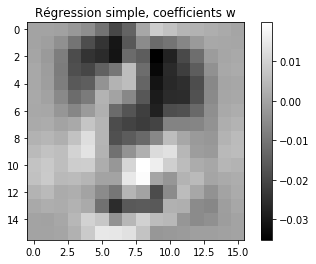

Par ailleurs, la norme du vecteur w est 0.17638962127145383


In [338]:
#///////////////////////////////////////////////////////////////////////////////////////////////// <observation du témoin> ////

# ··· Comment s'en sort la régression linéaire ?

print("Lancement d'une régression linéaire seule.")
regSimple = Lineaire(max_iter=1000,eps=0.0001)
regSimple.fit(xTrain, yTrain, xTest, yTest,init="mean")
scoreTrain, scoreTest = regSimple.score(xTrain,yTrain),regSimple.score(xTest,yTest)
vmin, vmax = np.min(regSimple.w), np.max(regSimple.w)

# Afficher le score obtenu et les poids.
plt.figure()
print("Score en train %f, score en test %f" %(scoreTrain,scoreTest))
plt.imshow(regSimple.w.reshape(16,16), cmap="gray")
plt.title("Régression simple, coefficients w")
plt.colorbar()
plt.show()

print("Par ailleurs, la norme du vecteur w est", np.linalg.norm(regSimple.w))

#//////////////////////////////////////////////////////////////////////////////////////////////// </observation du témoin> ////

Ce résultat bien observé, on peut passer à la première phase du protocole.  
Le code suivant, lancé une seule fois, permet de créer tous les graphiques de comparaison ultérieurs.  
Il s'agit de comparer Ridge et LASSO pour douze valeurs différentes de $\alpha$, de 0 à 100.  
Rappel : pour $\alpha$=0, ce n'est rien d'autre qu'une régression linéaire simple.

In [339]:
#////////////////////////////////////////////////////////////////////////////////////////////////// <expérience sur alpha> ////

# ··· Situation de Ridge et LASSO pour diverses valeurs d'alpha.

lAlpha = [0, 0.0001, 0.001, 0.05, 0.1, 0.5, 1, 2.5, 5, 10, 20, 100]

print("Compilation des résultats en cours pour toutes les valeurs d'alpha.")
scoreTrainRidge = []
scoreTestRidge = []
scoreTrainLasso = []
scoreTestLasso = []
wRidge= []
wLasso = []
for alpha in lAlpha:   
    # Construire le classifieur avec la régularisation donnée.
    regRidge = Lineaire(regularization="ridge",max_iter=1000,eps=0.0001,alpha=alpha)
    regLasso = Lineaire(regularization="lasso",max_iter=1000,eps=0.0001,alpha=alpha)
    # Apprentissage.
    regRidge.fit(xTrain,yTrain,init="mean")
    regLasso.fit(xTrain,yTrain,init="mean")
    # Calcul du score et conservation des poids associés.
    scoreTrainRidge.append(regRidge.score(xTrain,yTrain))
    scoreTestRidge.append(regRidge.score(xTest,yTest))
    scoreTrainLasso.append(regLasso.score(xTrain,yTrain))
    scoreTestLasso.append(regLasso.score(xTest,yTest))
    wRidge.append(regRidge.w.reshape(-1))
    wLasso.append(regLasso.w.reshape(-1))
print("Terminé.")
    
#///////////////////////////////////////////////////////////////////////////////////////////////// </expérience sur alpha> ////

#### 1.1.1 Comparaison selon les poids retournés

<a id='poids'></a>

Affichage des vecteurs de poids, sous forme d'image, pour Ridge à droite et LASSO à gauche.

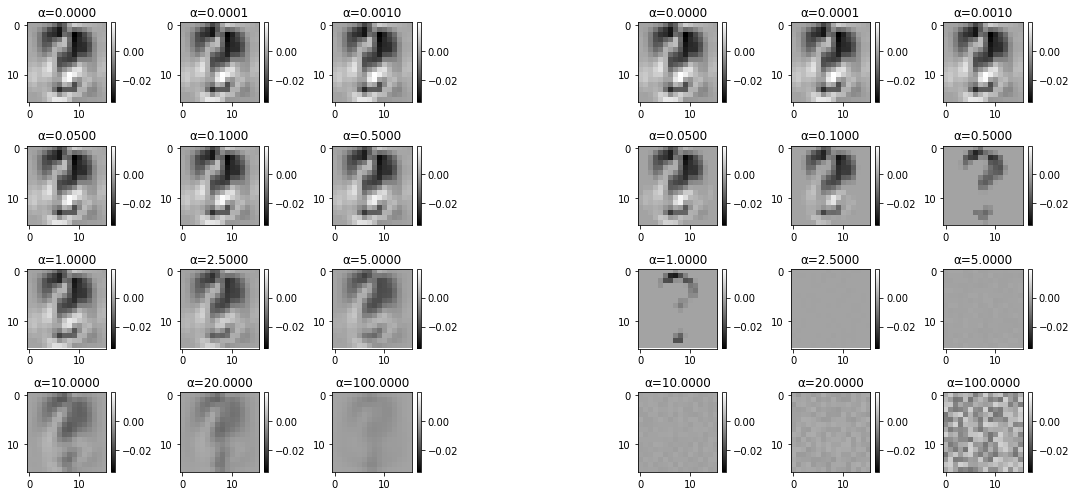

In [340]:
#/////////////////////////////////////////////////////////////////////////////////////////// <affichage des poids selon α> ////

fig = plt.figure(figsize=(15,7))
i_ridge = [1, 2, 3, 8, 9, 10, 15, 16, 17, 22, 23, 24]
i_lasso = [5, 6, 7, 12, 13, 14, 19, 20, 21, 26, 27, 28]

for k, slot in enumerate(i_ridge):
    data = wRidge[k].reshape(16,16)
    fig.add_subplot(4, 7, slot)
    plt.title("α=%.4f"% (lAlpha[k]))
    im = plt.imshow(data, vmin=vmin, vmax=vmax, cmap='gray')
    fig.colorbar(im,fraction=0.045)
    fig.subplots_adjust(wspace = 0, hspace=0)
        
for k, slot in enumerate(i_lasso):
    data = wLasso[k].reshape(16,16)
    fig.add_subplot(4, 7, slot)
    plt.title("α=%.4f"% (lAlpha[k]))
    im = plt.imshow(data, vmin=vmin, vmax=vmax, cmap='gray')
    fig.colorbar(im,fraction=0.045)
    fig.subplots_adjust(wspace = 0, hspace=0)

fig.tight_layout()
plt.show()

#////////////////////////////////////////////////////////////////////////////////////////// </affichage des poids selon α> ////

Pour les deux régressions, le paramètre $\alpha$ a le don d'annuler les coefficients w. Ils diminuent au fur et à mesure qu'$\alpha$ augmente. On constate bien sur le graphique précédent que tout finit par s'égaliser en gris moyen. Par contre, il y a des différences entre la gauche et la droite.

Pour de forts $\alpha$s, Ridge diminue systématiquement les coefficients w, pour absolument toutes les dimensions du modèle, quel que soit leur degré de corrélation.  
En revanche, LASSO sélectionne un seul caractère parmi les plus corrélés et déprécie les autres. Après cette phase de sélection, dont l'algorithme tire son nom, certains des coefficients gardent donc leur valeur telle quelle malgré la régularisation : c'est pourquoi on observe cette forme de 'point d'interrogation' qui demeure tout du long et qui correspond à la forme en creux du 6. Là, les poids demeurent négatifs pour pénaliser les données qui présenteraient des pixels forts à cet endroit - et donc les classer en -1. Persister à vouloir encore augmenter $\alpha$ finit par générer des coefficients plus ou moins aléatoires qui s'apparentent à du bruit : c'est que la convergence ne se fait plus du tout (cf. <a href= "#annexe"> 1.1.6 Annexe</a>).


#### 1.1.2 Comparaison selon la norme des poids

<a id='normes'></a>

On va également étudier l’effet de la régularisation sur le vecteur de poids obtenu en termes de norme. Elle aussi diminue.

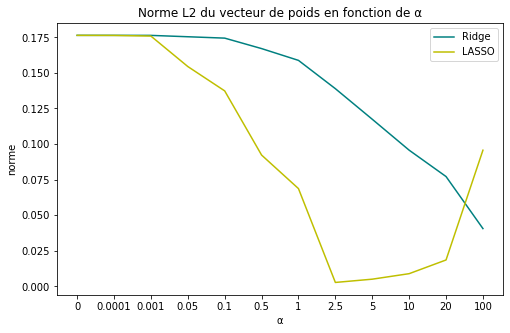

In [341]:
#///////////////////////////////////////////////////////////////////////////////////////// <évolution de la norme selon α> ////

normRidge = np.linalg.norm(wRidge,axis=1)
normLasso = np.linalg.norm(wLasso,axis=1)
plt.figure(figsize=(8,5))
plt.title("Norme L2 du vecteur de poids en fonction de α")
plt.plot(normRidge, label="Ridge", color='teal')
plt.plot(normLasso, label="LASSO", color='y')
plt.xticks(np.arange(len(lAlpha)),lAlpha)
plt.xlabel("α")
plt.ylabel("norme")
plt.legend()
plt.show()

#//////////////////////////////////////////////////////////////////////////////////////// </évolution de la norme selon α> ////

On sait que la complexité du modèle est proportionnellement liée à la norme de **w**, c'est-à-dire à la quantité sommée des poids. Cette quantité, naturellement, diminue quand certains de ces poids s'annulent, abaissant ainsi la complexité du modèle d'un cran.  
C'est donc que la complexité du modèle diminue comme la valeur de $\alpha$ augmente. Et c'est l'objectif.  

Pour les mêmes valeurs d'$\alpha$, les poids donnés par le Lasso deviennent rapidement beaucoup plus faibles que ceux de la régression Ridge. La régularisation est donc beaucoup plus forte en ce sens. Alors qu'on s'attend à ce que la norme tende vers 0, on constate cependant une "remontée" de la norme finale pour des $\alpha$s extrêmes, qu'on explique par l'impossibilité de converger en un nombre d'itérations limité (cf. <a href= "#annexe"> 1.1.6 Annexe</a>).

#### 1.1.3 Comparaison selon les scores de classification

<a id='scores'></a>

Caractérisation des performances en train et en test en fonction d'$\alpha$, pour les deux types de pénalisation.

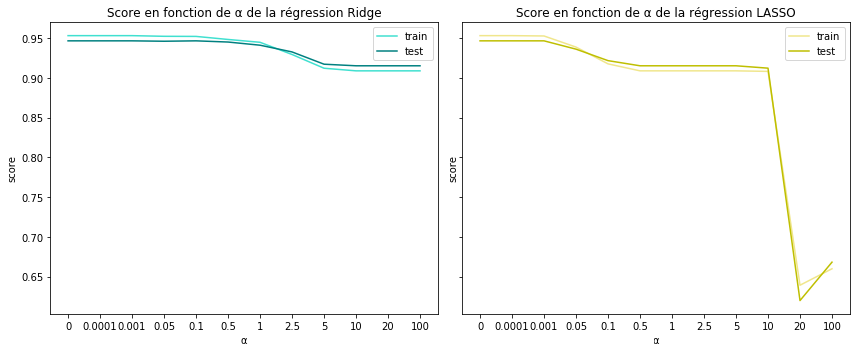

In [342]:
#//////////////////////////////////////////////////////////////////////////////////////////// <évolution du score selon α> ////

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].set_title("Score en fonction de α de la régression Ridge")
ax[0].plot(scoreTrainRidge, label="train", color='turquoise')
ax[0].plot(scoreTestRidge, label="test", color='teal')
ax[0].set_xticks(np.arange(len(lAlpha)))
ax[0].set_xticklabels(lAlpha)
ax[0].set_xlabel("α")
ax[0].set_ylabel("score")
ax[0].legend()
ax[1].set_title("Score en fonction de α de la régression LASSO")
ax[1].plot(scoreTrainLasso, label="train", color="khaki")
ax[1].plot(scoreTestLasso, label="test", color='y')
ax[1].set_xticks(np.arange(len(lAlpha)))
ax[1].set_xticklabels(lAlpha)
ax[1].set_xlabel("α")
ax[1].set_ylabel("score")
ax[1].legend()

fig.tight_layout()
plt.show()

#/////////////////////////////////////////////////////////////////////////////////////////// </évolution du score selon α> ////

Globalement, plus $\alpha$ augmente, moins les scores sont bons. Les modèles deviennent plus "généraux", la complexité du modèle diminue, on s'attend donc bien à quelque chose qui colle moins aux données. Ce n'est pas grave.
Par contre, les performances en test suivent la même dynamique ; on ne peut donc pas dire que le modèle devient _absolument_ "meilleur" en limitant, grâce à la régularisation, une forme spécifique de surapprentissage.

On observe sur les deux graphiques _un point d'intersection_ des courbes de score, où l'on "inverse" les scores train et test (pour Ridge, l'inversion a lieu pour $\alpha$  = 3, pour LASSO, $\alpha$ = 0.06).

- _Avant ce point: scoreTrain > scoreTest_. C'est un très léger cas de sur-apprentissage, qu'on peut imaginer beaucoup plus grave sur des modèles complexes. Chez nous, l'écart entre les courbes n'est pas important.

- _Après ce point: scoreTest > scoreTrain_. Le modèle est généralisé comme on l'a souhaité. 

Attention, des valeurs $\alpha$ trop élevées peuvent entraîner un sous-ajustement important, ce qu'on observe avec un décrochage important à partir d'$\alpha$  = 20 pour LASSO, et un essouflement plus léger à partir d'$\alpha$  = 5 pour Ridge. Ce genre de sous-ajustement signifie concrètement un sous-apprentissage, les dimensions deviennent insuffisantes (on s'en doutait en observant l'image des poids...) et les scores conséquents sont médiocres.

#### 1.1.4 Comparaison selon l'erreur MSE finale

<a id='erreur'></a>

Observation de la "distance" aux labels réels.

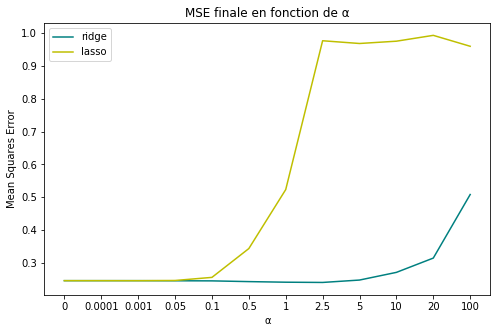

In [343]:
#////////////////////////////////////////////////////////////////////////////////// <évolution de l'erreur finale selon α> ////

mseRidge = []
for w in wRidge: mseRidge.append(mse(xTrain,yTrain,w))
mseLasso = []
for w in wLasso: mseLasso.append(mse(xTrain,yTrain,w))

plt.figure(figsize=(8,5))
plt.title("MSE finale en fonction de α")
plt.plot(mseRidge, label="ridge", color='teal')
plt.plot(mseLasso, label="lasso", color='y')
plt.xticks(np.arange(len(lAlpha)),lAlpha)
plt.xlabel("α")
plt.ylabel("Mean Squares Error")
plt.legend()

plt.show()

#///////////////////////////////////////////////////////////////////////////////// </évolution de l'erreur finale selon α> ////

Le coût aux moindres carrés augmente avec $\alpha$, ce qui traduit un modèle non abouti - c'est-à-dire que l'ajustement aurait pu continuer pour se rapprocher des poids optimaux. Pourtant, les classifieurs ont tous effectué le même nombre d'itérations, c'est donc que la régularisation nous éloigne de ces poids optimaux (ce qui est une nouvelle fois tout à fait attendu au vu des poids observés en 1.1.1 : ils n'étaient pas toujours cohérents).

Pour les deux, l'erreur finale reste assez faible et constante pour des $\alpha$ réduits. Mais cela ne dure que jusqu'au point d'inflexion dont nous avions déjà parlé plus haut : $\alpha$  = 2.5 pour Ridge, $\alpha$ = 0.05 pour LASSO, et à partir de là les valeurs explosent.

Pour le même $\alpha$, on observe que l'algorithme LASSO garde systématiquement une MSE plus élevée (ajustement moins bon) que la régression Ridge. Il finit même par atteindre un plateau où la MSE finale vaut systématiquement ~1. C'est donc qu'on "coupe" plus de matière qu'avec Ridge, en sacrifiant plus ou moins la justesse à la simplicité.

#### 1.1.5 Comparaison selon les composantes non nulles

<a id='nonnuls'></a>

On a bien vu que les poids se réduisaient pour les deux régularisations, mais peut-on dire qu'ils s'annulent ? Disparaissent-ils réellement pour élaguer le modèle, ou jouent-ils encore un rôle discret ?

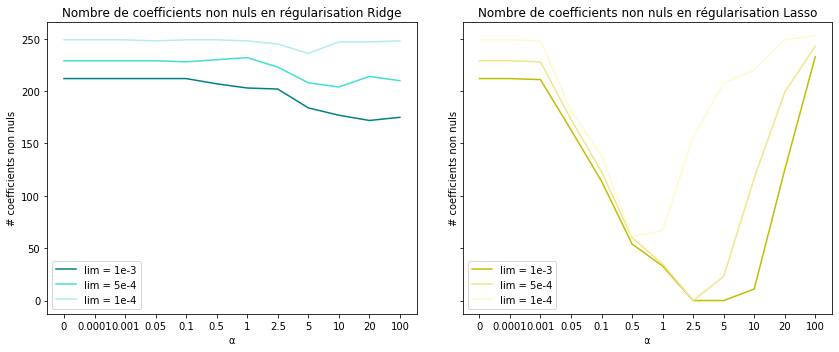

In [344]:
#////////////////////////////////////////////////////////////////////////// <évolution des composantes non nulles selon α> ////

# ··· Les coefficients sont dits nuls s'ils descendent en-dessous d'un epsilon donné.
# On trace trois de ces frontières.

eps1 = 1e-3
zerosRidge1 = np.sum(np.abs(wRidge)>eps1,axis=1)
zerosLasso1 = np.sum(np.abs(wLasso)>eps1,axis=1)
eps2 = 5e-4
zerosRidge2 = np.sum(np.abs(wRidge)>eps2,axis=1)
zerosLasso2 = np.sum(np.abs(wLasso)>eps2,axis=1)
eps3 = 1e-4
zerosRidge3 = np.sum(np.abs(wRidge)>eps3,axis=1)
zerosLasso3 = np.sum(np.abs(wLasso)>eps3,axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Nombre de coefficients non nuls en régularisation Ridge")
ax[0].plot(zerosRidge1, label="lim = 1e-3", color='teal')
ax[0].plot(zerosRidge2, label="lim = 5e-4", color='turquoise')
ax[0].plot(zerosRidge3, label="lim = 1e-4", color='paleturquoise')
ax[0].set_xticks(np.arange(len(lAlpha)))
ax[0].set_xticklabels(lAlpha)
ax[0].set_xlabel("α")
ax[0].set_ylabel("# coefficients non nuls")
ax[0].legend()
ax[1].set_title("Nombre de coefficients non nuls en régularisation Lasso")
ax[1].plot(zerosLasso1, label="lim = 1e-3", color='y')
ax[1].plot(zerosLasso2, label="lim = 5e-4", color='khaki')
ax[1].plot(zerosLasso3, label="lim = 1e-4", color='lemonchiffon')
ax[1].set_xticks(np.arange(len(lAlpha)))
ax[1].set_xticklabels(lAlpha)
ax[1].set_xlabel("α")
ax[1].set_ylabel("# coefficients non nuls")
ax[1].legend()

fig.tight_layout()
plt.show()

#///////////////////////////////////////////////////////////////////////// </évolution des composantes non nulles selon α> ////

On se rend compte que les coefficients de Ridge, bien que très petits, ne sont _pas_ nuls.  
Ce n'est pas pareil pour LASSO, où même de petits $\alpha$s (comme 0.0001) entraînent l'annulation d'un nombre significatif de coefficients. Ce qui est particulier pour LASSO, c'est la forme en creux de la courbe. On la doit au phénomène des solutions dites "creuses", ou "sparse". Dans le creux de la courbe, les dimensions sélectionnées par la régularisation sont très rares : on rappelle qu'on rase tout dans les clusters de dimensions corrélées (en jugeant de plus en plus radicalement de cette corrélation en fonction d'$\alpha$), à l'exclusion d'une seule _feature_ censée résumer l'information.  
On notera que l'annulation d'une majorité de coefficients ne concerne plus les $\alpha$s supérieurs à 5. Ce n'est pas qu'ils se régénèrent ; c'est encore lié à l'absence de convergence).

#### 1.1.6 Annexe

<a id='annexe'></a>

On a constaté une différence dans le nombre d'itérations nécessaires pour la convergence en fonction d'$\alpha$. 

En augmentant $\alpha$, le nombre d'itérations nécessaires pour Ridge diminue, il augmente pour LASSO. L'algorithme LASSO ne converge plus en un nombre d'itérations raisonnable (pas même en 2k it.) pour les grands $\alpha$ (1,2.5,5,10,20,100) et le calcul commence à prendre trop de temps. Or, nous avons décidé de limiter le nombre maximal d'itérations à 1000 pour tout le monde, dépasser cette limite serait contreproductif.

<code>ridge stopped at iteration: 112 , alpha =  0  
ridge stopped at iteration: 112 , alpha =  0.0001  
ridge stopped at iteration: 112 , alpha =  0.001  
ridge stopped at iteration: 111 , alpha =  0.05  
ridge stopped at iteration: 111 , alpha =  0.1  
ridge stopped at iteration: 109 , alpha =  0.5  
ridge stopped at iteration: 106 , alpha =  1  
ridge stopped at iteration: 99 , alpha =  2.5  
ridge stopped at iteration: 89 , alpha =  5  
ridge stopped at iteration: 74 , alpha =  10  
ridge stopped at iteration: 56 , alpha =  20  
ridge stopped at iteration: 20 , alpha =  100  
  
lasso stopped at iteration: 310 , alpha =  0  
lasso stopped at iteration: 310 , alpha =  0.0001  
lasso stopped at iteration: 310 , alpha =  0.001  
lasso stopped at iteration: 316 , alpha =  0.05  
lasso stopped at iteration: 322 , alpha =  0.1  
lasso stopped at iteration: 393 , alpha =  0.5</code>

Et LASSO ne converge pas pour le reste. Ce sont des cas où la régularisation est beaucoup trop extrême.

### 1.2 Conclusions générales de l'expérience

<a id='ccl'></a>

Déjà, l'impact du paramètre $\alpha$ a été étudié en détail.  
En général, pour Ridge comme pour LASSO, un $\alpha$ nul donnera les mêmes coefficients que pour la régression linéaire simple.
Alors qu'il tend vers l'infini, tous les coefficients deviennent absolument nuls en fin de convergence. La vitesse d'annulation est réglée selon l'intensité d'$\alpha$.  
Pour 0 < $\alpha$ < ∞, les coefficients seront donc compris entre 0 et ceux d'une régression linéaire simple, ils ne seront jamais supérieurs.

Voilà pour les remarques globales.  
Cela ne nous renseigne pas sur les différences entre Ridge, LASSO, et l'absence de régularisation.  
Ce que nous avons remarqué d'autre au cours des expériences a évidemment un impact sur les circonstances d'utilisation des trois méthodes.  

1. ***Différence principale***

La régularisation Ridge porte sur **toutes les dimensions** du modèle. En réduisant massivement la norme du vecteur de poids, son principal avantage est de réduire "uniformément" la complexité du modèle, mais les coefficients demeurent non nuls.  
La régularisation LASSO réduit aussi la complexité du modèle, cette fois en **extrayant une seule dimension par cluster corrélé**. Elle est donc plus radicale. Elle crée des solutions dites "creuses", ce qui équivaut tout de même à exclure des caractéristiques entières du modèle. Il faut en avoir conscience.

2. ***Use cases***

La technique Ridge empêche certainement le surapprentissage en **bridant les coefficients**, mais n'a pas d'utilité mesurable lorsque le modèle est de très grande dimension - dans ce cas, le passage par une régularisation ne fera que multiplier le temps de calcul.  
L'algorithme LASSO est justement indiqué dans ces cas précis. **Une solution creuse est un bon choix pour réduire les charges de calcul** : dès lors qu'on décide qu'un coefficient est nul, toutes les valeurs liées peuvent simplement être ignorées.  
Sans optimisation, cependant, le temps d'exécution du LASSO est vraiment lent.

3. ***Présence de dimensions hautement corrélées***

Pour Ridge, la régression fonctionne même en présence de caractéristiques hautement corrélées. Elles seront toutes incluses dans le modèle, les coefficients liés seront simplement répartis entre elles.
LASSO, on l'a compris, sélectionnerait arbitrairement n'importe quelle dimension parmi elles et réduirait les coefficients du reste à zéro. C'est donc que les caractéristiques vont changer aléatoirement avec le changement de paramètre du modèle.  
  
<a href="#protocole">Retour au protocole</a>
    

## 2. Corps du projet : Inpainting grâce à la méthode du LASSO

<a id='projet'></a>

Nous appliquerons la méthode du LASSO au traitement d'images.  
Elle permet de reconstruire des images détériorées à partir des pixels qu'on peut sauver. Les couleurs de ces pixels servent de base de peinture ; ce sont celles qu'on peut utiliser, mélanger, pour reformer celles qui manquent ; en termes mathématiques, on cherche donc à en faire une combinaison linéaire.  

Naturellement, un apprentissage pixel par pixel serait beaucoup trop long et exhaustif, et ne permettrait pas de rendre compte des textures locales. On agit donc sur l'image en la découpant sous forme de patches carrés de côté donné.
Apprendre la liste des patches sains nous autorise à estimer les valeurs pour un patch semblable dont tout ou partie serait manquante.

L'intérêt du LASSO lorsqu'on recherche la combinaison linéaire idéale est de pouvoir reconstruire un patch à partir d'un sous-ensemble du reste, _et non pas de la totalité des autres patches_. On se souvient que la régularisation LASSO permet d'annuler certains des poids et donc d'ignorer beaucoup de dimensions dans les clusters fortement corrélés. De fait, intuitivement, nul besoin de réutiliser toute une image pour remplir une zone localement amochée : le calcul des poids est fortement allégé.

<a href='#corriger'>Passer directement à la correction individuelle</a>  
<a href='#ensemble'>Passer directement à la correction d'ensemble</a>  
<a href='#remplacer'>Passer directement au remplissage de zones</a>

### 2.1 Fonctions de base

Implémentation des utilitaires qui permettent les actions de base.
Il y a ici de quoi 
- lire (<code>readIm</code>) et afficher (<code>imshow</code>) une image en codage RGB, sachant que l'on travaille en interne sur sa version HSV
- normaliser (<code>normalizeImage</code>, <code>normalizeColorImage</code>) les valeurs de l'image, ce qui est utile pour l'affichage et la régression
- faire des misères à une image, notamment en la bruitant (<code>noise</code>) selon un pourcentage donné, ou même en supprimant une partie (<code>deleteRect</code>)
- récupérer (<code>getPatch</code>) un patch d'une image, carré de côté h et centré en i, j
- effectuer les conversions entre un patch et un vecteur (<code>convertoPatch</code>, <code>convertoVect</code>)
- récupérer l'index (<code>qualifyPixPatch</code>) des patches bruités et sains.

On reviendra rapidement ci-dessous sur cet index, essentiel dans ce projet, et son usage.
On ajoute à cet ensemble de base la fonction <code>getNonNull</code>. Elle retourne les valeurs d'un dictionnaire qui ne sont pas proches de zéro (elle servira à l'affichage des poids retournés par le LASSO).

Le choix de travailler en HSV pour les calculs est lié à la plage des valeurs de normalisation (avoir des canaux à trois couleurs dans ce cas peut générer de fausses associations).

In [5]:
#///////////////////////////////////////////////////////////////////////////////////////////////////// <fonctions de base> ////

def normalizeImage(I,kmin,kmax,Imin=None,Imax=None):
    # Normalisation entre kmin et kmax pour une image en niveaux de gris.
    Ic = np.copy(I)
    if Imin == None: Imin = np.min(Ic)
    if Imax == None: Imax = np.max(Ic)
    Ic = ((Ic-Imin)*((kmax-kmin)/(Imax-Imin)))+kmin
    return Ic

def normalizeColorImage(I,kmin,kmax,Imin=None,Imax=None):
    # Normalisation entre kmin et kmax pour chaque canal d'une image en couleur.
    I0 = normalizeImage(I[:,:,0],kmin,kmax,Imin,Imax)
    I1 = normalizeImage(I[:,:,1],kmin,kmax,Imin,Imax)
    I2 = normalizeImage(I[:,:,2],kmin,kmax,Imin,Imax)
    I = np.stack((I0,I1,I2),axis=2)
    return I

def readIm(fn):
    # Lecture d'une image, à convertir en HSV.
    # Retour de l'image sous forme d'un array.
    ar = plt.imread(fn)
    ar = rgb_to_hsv(ar) # conversion en HSV
    ar = normalizeColorImage(ar,-1,1) # normalisation entre -1 et 1 
    return ar
        
def imshow(I,title=None, size=500, axis=False): 
    # Affichage de l'image HSV (reconvertie en RGB)
    Ic = np.copy(I)
    mask = (Ic == -100) 
    Ic[mask]=-0.3
    # Le bruit en noir (-1) est un peu agressif pour les yeux
    # Normalisation.
    Ic = normalizeColorImage(Ic,kmin=0,kmax=1,Imin=-1,Imax=1) 
    Ic = hsv_to_rgb(Ic) # conversion HSV to RGB
    plt.imshow(Ic)
    if not axis: plt.axis('off')
    if title: plt.title(title)
        
def noise(I,prc):
    # Bruitage de l'image : bruit poivre (pixels noirs disséminés).
    # Technique de tirage aléatoire vue en MAPSI.
    noise = np.random.rand(I.shape[0],I.shape[1])<=prc
    # Aux points concernés, affecter la valeur arbitraire de -100.
    img_out = I.copy()
    for i in range(3):
        img_out[:,:,i] = np.where(noise,-100,I[:,:,i]) 
    return img_out

def deleteRect(I,i,j,height,width):
    # Disparition d'un rectangle de l'image, de taille height*width, centré en i,j.
    # Veiller à ce que les limites du rectangle données en paramètre soient traitées
    # si elles dépassent celles de l'image.
    im = I.copy()
    if i-(height//2)<0: hmin = 0
    else: hmin = i-(height//2)
    if i+(height//2)>I.shape[0]: hmax = I.shape[0]
    else: hmax = i+(height//2)
    if j-(width//2)<0: wmin = 0
    else: wmin = j-(width//2)
    if j+(width//2)>I.shape[1]: wmax = I.shape[1]
    else: wmax = j+(width//2)
    # Remplir en noir.
    im[hmin:hmax,wmin:wmax,:] = np.ones((hmax-hmin,wmax-wmin,3))*-100
    return im

def getPatch(I,i,j,h):
    # Récupérer le patch de longueur h, centré en i,j.
    imin = i-(h//2)
    jmin = j-(h//2)
    return I[imin:imin+h, jmin:jmin+h, :]

def convertoVec(patch):
    # Pouvoir jongler entre patchs et vecteurs.
    return patch.reshape((-1))

def convertoPatch(vect):
    h = int(np.sqrt(vect.size/3))
    return vect.reshape(h, h, 3)

def qualifyPixPatch(I,h,step):
    # Retrouver les patches concernés par les pixels manquants,
    # et en complément ceux qui forment le dictionnaire.
    tomend = {}
    tokeep = {}
    # Parcourir l'image.
    for i in range((h//2),I.shape[0]-(h//2),step):
        for j in range((h//2),I.shape[1]-(h//2),step):
            # Se demander, patch par patch, s'il y a un défaut.
            patch = getPatch(I,i,j,h)
            if -100 in patch: tomend[(i,j)] = patch
            else: tokeep[(i,j)] = patch
    return tokeep, tomend

def getNonNull(dic):
    # Copier et supprimer les valeurs nulles du dictionnaire.
    killnull = {}
    for k in list(dic.keys()):
        if not np.allclose(dic[k], 0): killnull[(k)]=dic[k]
    return killnull
    
#///////////////////////////////////////////////////////////////////////////////////////////////////// <fonctions de base> ////

En ce qui concerne le dictionnaire, les deux paramètres <code>h</code> et <code>step</code> ont leur importance.
Pour ne pas obtenir un dictionnaire trop lourd, on décide d'échantillonner les patches de longueur <code>h</code> tous les pas de pixels <code>step</code> (<code>step</code> peut valoir 1 pour un apprentissage exhaustif).
Les patches résultants se superposent ou non en fonction du rapport entre <code>h</code> et <code>step</code> : 
- <code>h = step</code> : quadrillage parfait de l'image, mais on élague de l'information potentiellement utile pour l'apprentissage
- <code>h</code> < <code>step</code> : si l'image est une texture régulière, c'est permis ; sinon il reste des gaps entre les patches, soit vraiment beaucoup d'information manquante
- <code>h</code> > <code>step</code> : apprentissage de plus en plus exhaustif en fonction de la petitesse de <code>step</code> : deux patches successifs du dictionnaire se superposent. Quand <code>step = 1</code>, on apprend absolument tous les patches possibles.

Il faut trouver le juste milieu lors du paramétrage pour le calcul du dictionnaire, cf. annexe.

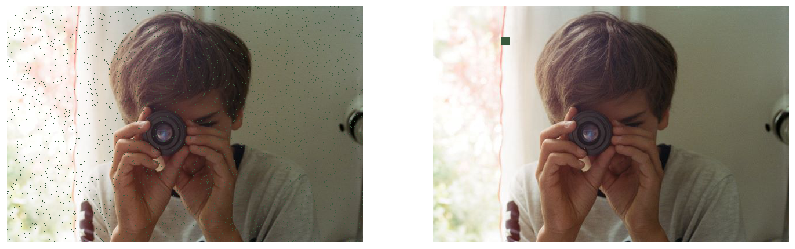

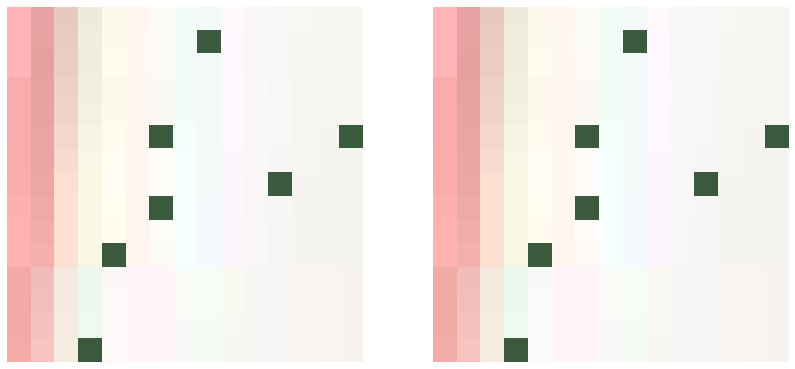

Calcul du dictionnaire :  91  patches sains contre  9389  patches à réparer.


In [550]:
#///////////////////////////////////////////////////////////////////////////////////////////////// <tests starting-blocks> ////

# ··· Prétraitements pour une image type.

obj = readIm("src/obj.jpg")
# Ajout d'un bruit poivre.
noi = noise(obj,0.02)
display = plt.figure(figsize=(14,7))
ax1 = display.add_subplot(121)
ax1 = imshow(noi)
# Suppression d'une zone.
ax2 = display.add_subplot(122)
ax2 = imshow(noi)
imshow(deleteRect(obj,60,125,15,15))
plt.show()
# Récupération d'un patch,
tch = getPatch(noi,60,125,15)
# conversion, reconstruction.
reconstruct = plt.figure(figsize=(14,7))
ax1 = reconstruct.add_subplot(121)
ax1 = imshow(tch)
arr = convertoVec(tch)
tch = convertoPatch(arr)
ax2 = reconstruct.add_subplot(122)
ax2 = imshow(tch)
plt.show()

# Dictionnaires de l'image bruitée, quadrillage de 3 en 3.
dicts = qualifyPixPatch(noi,15,5)
print("Calcul du dictionnaire : ", len(dicts[0])," patches sains contre ",len(dicts[1])," patches à réparer.")

# Tout va bien.

#//////////////////////////////////////////////////////////////////////////////////////////////// </tests starting-blocks> ////

### 2.2 Reconstruction des patches individuels

<a id='corriger'></a>
On appelle "atomes" les patches sains issus du calcul du dictionnaire sur une image.  
Ce sera notre palette.  

#### 2.2.1 Fonction de reconstruction

<code>approximatePatch(patch, atoms, alpha = 0.01, prediction=True)</code>  
***Arguments*** : patch bruité, atomes de l'image originale, paramètre alpha, booléen pour le retour.

***Objectifs*** : La fonction de reconstruction ci-dessous est capable de "repeindre" les pixels manquants sur un patch bruité passé en argument, à partir des atomes de l'image qui sont eux aussi passés en argument.

***Outils*** : 
La fonction utilise le LASSO de <code>sklearn</code>. La lenteur de la convergence du LASSO maison est rédhibitoire, et à partir d'ici, on aura besoin d'utiliser une implémentation optimisée.  
Demeure chez <code>sklearn</code> le paramètre $\alpha$ longuement étudié qui permet de régler l'intensité de la régularisation.

***Fonctionnement*** : La fonction doit trouver, parmi les atomes fournis, ceux qui sont les plus informatifs pour la reconstruction du patch. Elle cherche en fait ceux qui correspondent aux parties saines du patch en question, ce qui va automatiquement permettre de remplir ce qui manque : en termes techniques, on parle de retrouver les "isophotes".  
Elle doit donc créer une combinaison linéaire où ces atomes pèsent plus ou moins ; de nouveau, l'avantage du LASSO est que la plupart des poids seront nuls, comme expliqué plus haut.  
Selon le choix du paramètre booléen, elle peut soit retourner les poids en question, seuls, soit proposer le patch débruité en accompagnement.

On a l'intuition qu'une régularisation trop puissante avec $\alpha$ serait néfaste, puisqu'il s'agirait alors d'annuler tous les poids pour tous les patches, y compris ceux qui auraient été importants car suffisamment similaires. On le vérifiera en <a href='#alphapaint'>2.2.3.</a>

In [6]:
#//////////////////////////////////////////////////////////////////////////////////////////// <fonction de reconstruction> ////

def approximatePatch(patch, atoms, alpha = 0.01, prediction=True):
    # Avec un patch et un dictionnaire des atomes en entrée, 
    # retourner le vecteur de poids sur le dictionnaire qui approxime au mieux le patch manquant
    # en utilisant l’algorithme du LASSO. 
    # Convertir le patch en vecteur Y.
    Y = convertoVec(patch)
    # Convertir les atomes en matrice d'exemples X.
    listKeys = list(atoms.keys())
    X = np.zeros((Y.size,len(listKeys)))
    for i, k in enumerate(listKeys):
        X[:,i] = convertoVec(atoms[k])
        
    # Régression Lasso.
    lasso = sklearn.linear_model.Lasso(alpha = alpha, fit_intercept = True, max_iter = 5000)
    # Apprendre la régression sur les pixels des atomes de X,
    # dont les indices correspondent à des pixels exprimés du patch Y. 
    mask = (Y != -100) # Sélectionner les indices des pixels correctement exprimés.
    lasso.fit(X[mask, :], Y[mask])
    # Associer les poids w aux clefs de notre dictionnaire.
    w = {k:lasso.coef_[i] for i, k in enumerate(listKeys)}
    
    # Renvoyer les poids w seuls si on ne veut pas de prédiction ;
    if not prediction: return w, patch
    # sinon, lancer l'approximation pour les pixels abîmés.
    nonMask = np.logical_not(mask) 
    newY = Y.copy()
    newY[nonMask] = lasso.predict(X[nonMask, :])
    return w, convertoPatch(newY)    

#/////////////////////////////////////////////////////////////////////////////////////////// </fonction de reconstruction> ////

#### 2.2.2 Protocoles de reconstruction

Notre objectif est double, pouvoir reconstruire des patches à partir  
- du dictionnaire de l'image *complète*, sans bruit, où seul le patch cible est détérioré (cas très peu naturel)  
- ou du dictionnaire de l'image *entièrement bruitée*, dont on a alors besoin d'extraire les atomes.  

Dans les deux cas, on parvient avec succès à prédire les valeurs localement manquantes.

Pour obtenir les dictionnaires, il a fallu mettre en place une superposition entre les patches, entre lecture pixel par pixel (surapprentissage) et quadrillage sans aucune intersection (gain de temps). Le paramétrage exact pour la taille des patches est difficile à trouver : il faut qu'il y ait au moins une dizaine de pixels non bruités dans le deuxième dictionnaire, sans quoi faire une combinaison linéaire n'a aucun sens.  
C'est pourquoi le patch et le pas sont si petits, sans quoi on ne trouve aucun atome.  
On pourra corriger des régions plus grandes en apprenant sur plusieurs patches. C'est ce qu'on fera un peu plus bas.

On s'est aussi demandé si restreindre l'image à la partie qui ressemble au patch était ou non plus intelligent.
L'image que nous avons choisie contient un grand nombre de textures, le LASSO saurait-il faire la différence ?

Sur l'apprentissage partiel, 2744 atomes dans l'image saine contre 25 dans l'image bruitée.
Sur l'apprentissage complet, 9480 atomes dans l'image saine contre 91 dans l'image bruitée.
Quatre tentatives de reconstruction en cours.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


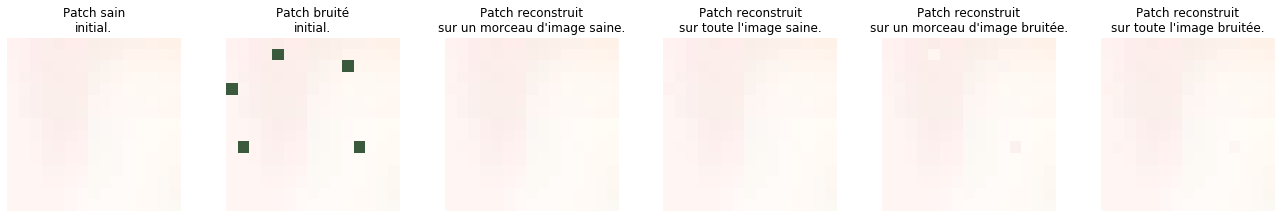

In [554]:
#/////////////////////////////////////////////////////////////////////////////////////////////// <essai sur un seul patch> ////

# ··· Une reconstruction facile.
init = getPatch(obj,80,80,15)
tch = getPatch(noi,80,80,15)

# CAS 1 : atomes de l'image originale, image partielle.
dictintactPart = qualifyPixPatch(obj[:150,:500],15,5)[0]
# CAS 2 : atomes de l'image originale, image complète.
dictintactComp = qualifyPixPatch(obj,15,5)[0]
# CAS 3 : atomes de l'image bruitée, image partielle.
dictbruitePart = qualifyPixPatch(noi[:150,:500],15,5)[0]
# CAS 4 : atomes de l'image bruitée, image partielle.
dictbruiteComp = qualifyPixPatch(noi,15,5)[0]
print("Sur l'apprentissage partiel, %d atomes dans l'image saine contre %d dans l'image bruitée." %(len(dictintactPart),len(dictbruitePart)))
print("Sur l'apprentissage complet, %d atomes dans l'image saine contre %d dans l'image bruitée." %(len(dictintactComp),len(dictbruiteComp)))
print("Quatre tentatives de reconstruction en cours.")

# Apprendre le vecteur de poids sur les atomes de l'image originale partielle, pour qu'il reconstruise le patch au mieux.
winitP,patchiP = approximatePatch(tch,dictintactPart,alpha = 0.001)
# Apprendre le vecteur de poids sur les atomes de l'image originale complète, pour qu'il reconstruise le patch au mieux.
winitC,patchiC = approximatePatch(tch,dictintactComp,alpha = 0.001)
# Apprendre le vecteur de poids sur les atomes de l'image bruitée partielle, ce qui est plus réaliste.
wbruiP,patchbP = approximatePatch(tch,dictbruitePart,alpha = 0.001)
# Apprendre le vecteur de poids sur les atomes de l'image bruitée complète, ce qui est plus réaliste.
wbruiC,patchbC = approximatePatch(tch,dictbruiteComp,alpha = 0.001)

# Affichage.
reconstruct = plt.figure(figsize=(18,3))
ax0 = reconstruct.add_subplot(161)
ax0 = imshow(init,title="Patch sain\ninitial.")
ax1 = reconstruct.add_subplot(162)
ax1 = imshow(tch,title="Patch bruité\ninitial.")
ax2 = reconstruct.add_subplot(163)
ax2 = imshow(patchiP,"Patch reconstruit\nsur un morceau d'image saine.")
ax3 = reconstruct.add_subplot(164)
ax3 = imshow(patchiC,"Patch reconstruit\nsur toute l'image saine.")
ax4 = reconstruct.add_subplot(165)
ax4 = imshow(patchbP,"Patch reconstruit\nsur un morceau d'image bruitée.")
ax5 = reconstruct.add_subplot(166)
ax5 = imshow(patchbC,"Patch reconstruit\nsur toute l'image bruitée.")
plt.tight_layout()
plt.show()

#/////////////////////////////////////////////////////////////////////////////////////////////// <essai sur un seul patch> ////

L'apprentissage est franchement satisfaisant dans les quatre cas.
Quand on apprend sur une partie de l'image saine, le résultat est identique à l'apprentissage sur toute l'image, et on obtient quelque chose de vraiment similaire au patch initial.  
L'apprentissage sur l'image bruitée est meilleur quand il est complet (l'apprentissage partiel donne des pixels réparés très repérables), et le résultat dans ce cas est indiscernable de celui d'un apprentissage sur l'image saine.

In [562]:
#///////////////////////////////////////////////////////////////////////////// <essai sur un seul patch, détail des poids> ////

wnniP = getNonNull(winitP)
print("Sur l'image saine partielle, trouvé un nombre total de coefficients %d, dont %d non nuls" %(len(winitP),len(wnniP)))
print("\nqui sont", {k: np.around(v, decimals=4) for k, v in sorted(wnniP.items(), key=lambda item: abs(item[1]), reverse=True)})
wnniC = getNonNull(winitC)
print("\nSur l'image saine entière, trouvé un nombre total de coefficients %d, dont %d non nuls" %(len(winitC),len(wnniC)))
print("\nqui sont", {k: np.around(v, decimals=4) for k, v in sorted(wnniC.items(), key=lambda item: abs(item[1]), reverse=True)})
wnnbP = getNonNull(wbruiP)
print("\n\nSur l'image bruitée partielle, trouvé un nombre total de coefficients %d, dont %d non nuls" %(len(wbruiP),len(wnnbP)))
print("\nqui sont", {k: np.around(v, decimals=4) for k, v in sorted(wnnbP.items(), key=lambda item: abs(item[1]), reverse=True)})
wnnbC = getNonNull(wbruiC)
print("\nSur l'image bruitée entière, trouvé un nombre total de coefficients %d, dont %d non nuls" %(len(wbruiC),len(wnnbC)))
print("\nqui sont", {k: np.around(v, decimals=4) for k, v in sorted(wnnbC.items(), key=lambda item: abs(item[1]), reverse=True)})

#//////////////////////////////////////////////////////////////////////////// </essai sur un seul patch, détail des poids> ////

Sur l'image saine partielle, trouvé un nombre total de coefficients 2744, dont 66 non nuls

qui sont {(7, 7): 0.2835, (7, 22): 0.1071, (112, 52): 0.0854, (67, 47): 0.0663, (72, 112): 0.0516, (142, 107): 0.0439, (77, 82): 0.0392, (7, 127): 0.0341, (72, 47): 0.0264, (72, 37): 0.0261, (72, 97): 0.0219, (67, 42): 0.0183, (12, 7): 0.0153, (82, 52): 0.0139, (12, 107): 0.0133, (52, 112): 0.0102, (62, 52): 0.01, (112, 57): 0.0083, (72, 102): 0.0076, (77, 62): 0.0071, (77, 77): 0.007, (32, 47): 0.0068, (142, 117): 0.0066, (107, 112): 0.0064, (117, 57): 0.0062, (117, 17): 0.0059, (102, 112): 0.0056, (67, 77): 0.0056, (47, 112): 0.0055, (92, 117): 0.0052, (42, 122): 0.0047, (112, 122): 0.0044, (32, 112): 0.0039, (57, 32): 0.0036, (12, 112): 0.0036, (57, 122): 0.0036, (102, 107): 0.0035, (82, 347): -0.0034, (77, 37): 0.0034, (82, 117): 0.0033, (77, 342): -0.0033, (122, 122): 0.003, (127, 17): 0.0022, (87, 32): 0.0021, (132, 7): 0.0021, (112, 72): 0.0021, (7, 112): 0.002, (82, 37): 0.0017, (47, 47)

Ce n'est pas tant une surprise, mais sur l'image saine, le LASSO arrive à retrouver presque exactement les mêmes patches pour effectuer la combinaison (du moins pour les poids les plus importants), qu'on lui indique ou non la région où chercher. On retrouve bien d'ailleurs un très proche voisin du patch initial (7,7) en tête de liste.  

Sur l'image bruitée, c'est un peu plus compliqué. De fait, les choix de patches sains sont plus restreints. Les résultats différents entre l'apprentissage complet et partiel montrent qu'il est alors préférable d'utiliser des parties disparates de l'image (qui ne semblent pourtant pas adéquates de visu) dans la combinaison linéaire. Par exemple :

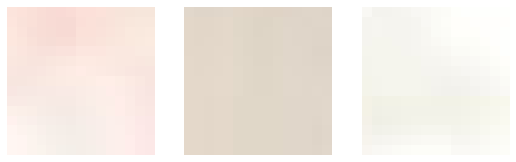

In [560]:
coll = plt.figure(figsize=(9,3))
ax0 = coll.add_subplot(131)
ax0 = imshow(getPatch(obj,152,72,15))
ax1 = coll.add_subplot(132)
ax1 = imshow(getPatch(obj,102,162,15))
ax2 = coll.add_subplot(133)
ax2 = imshow(getPatch(obj,222,22,15))
plt.show()

mais aussi :

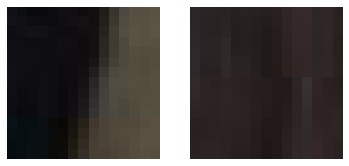

In [561]:
coll = plt.figure(figsize=(6,3))
ax0 = coll.add_subplot(121)
ax0 = imshow(getPatch(obj,252,407,15))
ax1 = coll.add_subplot(122)
ax1 = imshow(getPatch(obj,112,347,15))
plt.show()

Voilà pour une analyse détaillée. 

On se dit quand même que ce patch était beaucoup trop simple, et on confronte le LASSO à quelque chose de plus salé :

Sur l'apprentissage partiel, 7452 atomes dans l'image saine contre 60 dans l'image bruitée.
Sur l'apprentissage complet, 9480 atomes dans l'image saine contre 91 dans l'image bruitée.
Quatre tentatives de reconstruction en cours.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1858213675770597, tolerance: 0.04767730225369568
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31621927276806394, tolerance: 0.04767730225369568
  positive)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


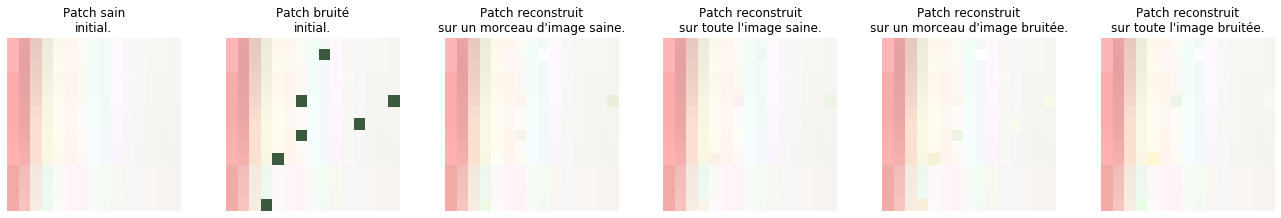

In [553]:
#/////////////////////////////////////////////////////////////////////////////////////////////// <essai sur un seul patch> ////

# ··· Juste un patch un peu plus compliqué à gérer.
init = getPatch(obj,60,125,15)
tch = getPatch(noi,60,125,15)

# CAS 1 : atomes de l'image originale, image partielle.
dictintactPart = qualifyPixPatch(obj[:150,:500],15,3)[0]
# CAS 2 : atomes de l'image originale, image complète.
dictintactComp = qualifyPixPatch(obj,15,3)[0]
# CAS 3 : atomes de l'image bruitée, image partielle.
dictbruitePart = qualifyPixPatch(noi[:150,:500],15,3)[0]
# CAS 4 : atomes de l'image bruitée, image partielle.
dictbruiteComp = qualifyPixPatch(noi,15,3)[0]
print("Sur l'apprentissage partiel, %d atomes dans l'image saine contre %d dans l'image bruitée." %(len(dictintactPart),len(dictbruitePart)))
print("Sur l'apprentissage complet, %d atomes dans l'image saine contre %d dans l'image bruitée." %(len(dictintactComp),len(dictbruiteComp)))
print("Quatre tentatives de reconstruction en cours.")

# Apprendre le vecteur de poids sur les atomes de l'image originale partielle, pour qu'il reconstruise le patch au mieux.
winitP,patchiP = approximatePatch(tch,dictintactPart,alpha = 0.001)
# Apprendre le vecteur de poids sur les atomes de l'image originale complète, pour qu'il reconstruise le patch au mieux.
winitC,patchiC = approximatePatch(tch,dictintactComp,alpha = 0.001)
# Apprendre le vecteur de poids sur les atomes de l'image bruitée partielle, ce qui est plus réaliste.
wbruiP,patchbP = approximatePatch(tch,dictbruitePart,alpha = 0.001)
# Apprendre le vecteur de poids sur les atomes de l'image bruitée complète, ce qui est plus réaliste.
wbruiC,patchbC = approximatePatch(tch,dictbruiteComp,alpha = 0.001)

# Affichage.
reconstruct = plt.figure(figsize=(18,3))
ax0 = reconstruct.add_subplot(161)
ax0 = imshow(init,title="Patch sain\ninitial.")
ax1 = reconstruct.add_subplot(162)
ax1 = imshow(tch,title="Patch bruité\ninitial.")
ax2 = reconstruct.add_subplot(163)
ax2 = imshow(patchiP,"Patch reconstruit\nsur un morceau d'image saine.")
ax3 = reconstruct.add_subplot(164)
ax3 = imshow(patchiC,"Patch reconstruit\nsur toute l'image saine.")
ax4 = reconstruct.add_subplot(165)
ax4 = imshow(patchbP,"Patch reconstruit\nsur un morceau d'image bruitée.")
ax5 = reconstruct.add_subplot(166)
ax5 = imshow(patchbC,"Patch reconstruit\nsur toute l'image bruitée.")
plt.tight_layout()
plt.show()

#/////////////////////////////////////////////////////////////////////////////////////////////// <essai sur un seul patch> ////

On se retrouve alors avec des ConvergenceWarning, et une reconstruction moins satisfaisante. Ce n'est pas la faute d'$\alpha$ qui a été choisi très faible exprès, mais bien de la difficulté de la tâche.
Rapporté à l'échelle, le rendu est convaincant.

#### 2.2.3 Etude du paramètre $\alpha$

<a id='alphapaint'></a>

Qu'en est-il justement de l'impact d'$\alpha$ ?

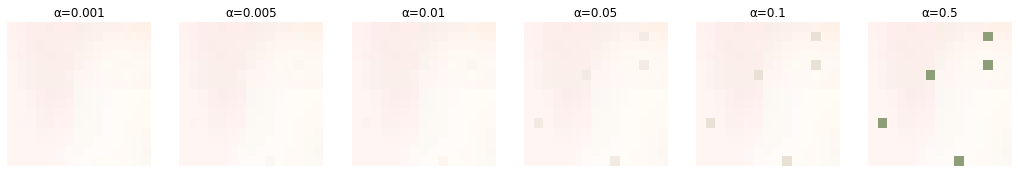

In [528]:
#//////////////////////////////////////////////////////////////////////////////////////////////////////// <impact d'alpha> ////

lAlpha = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
lw = []
lPatch = []

# Apprendre le vecteur de poids sur les atomes de l'image initiale pour divers alpha.
impacta = plt.figure(figsize=(18,3))
i=1
for alpha in lAlpha:
    w,patch = approximatePatch(tch,dictintactComp,alpha)
    lw.append(w)
    lPatch.append(patch)
    ax = impacta.add_subplot(160+i)
    ax = imshow(patch,title="α="+str(alpha),size=250)
    i+=1
plt.show()

#/////////////////////////////////////////////////////////////////////////////////////////////////////// </impact d'alpha> ////

On constate comme attendu que la régularisation excessive empêche le LASSO de retenir des patches pourtant importants pour la combinaison linéaire. Les pixels manquants ne sont même plus remplis.

<a href='#indiv'>Retour au remplissage individuel</a>

#### 2.2.4 Correction de toute l'image

<a id='ensemble'></a>

Il est possible de corriger la totalité d'une image en itérant sur les patches bruités pour les reconstruire. C'est ce qu'on va voir maintenant :

1075 patches à réécrire dans l'image bruitée.
9480 atomes dans l'image saine contre 91 dans l'image bruitée.
Deux tentatives de reconstruction en cours.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027812118114006947, tolerance: 0.024186446813786292
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06785077037710607, tolerance: 0.047642879599236986
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2185004547142384, tolerance: 0.023773216357580815
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.039952275301892826, tolerance: 0.019755616702334645
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12009744391373545, tolerance: 0.024030224494020407
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14397727061618326, tolerance: 0.023898960436650695
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

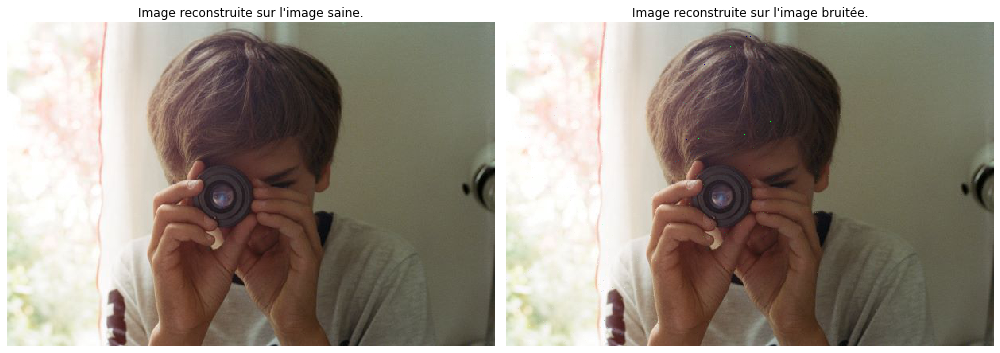

In [567]:
#/////////////////////////////////////////////////////////////////////////////////////////////// <reconstruction complète> ////

# ··· Peut-on remplir d'un coup tous les pixels de bruit ?

# Patches bruités de l'image bruitée.
dicttoMend = qualifyPixPatch(noi,15,15)[1]
print("%d patches à réécrire dans l'image bruitée." %(len(dicttoMend)))

# CAS 2 : atomes de l'image originale, image complète.
dictintactComp = qualifyPixPatch(obj,15,5)[0]
# CAS 4 : atomes de l'image bruitée, image partielle.
dictbruiteComp = qualifyPixPatch(noi,15,5)[0]
print("%d atomes dans l'image saine contre %d dans l'image bruitée." %(len(dictintactComp),len(dictbruiteComp)))
print("Deux tentatives de reconstruction en cours.")

imi = obj.copy()
imb = obj.copy()

for pos, patch in dicttoMend.items():
    # Apprendre le vecteur de poids sur les atomes de l'image originale complète, pour qu'il reconstruise le patch au mieux.
    winitC,patchiC = approximatePatch(patch,dictintactComp,alpha = 0.001)
    imi[pos[0]-15//2:pos[0]+15//2+1, pos[1]-15//2:pos[1]+15//2+1, :] = patchiC
    # Apprendre le vecteur de poids sur les atomes de l'image bruitée complète, ce qui est plus réaliste.
    wbruiC,patchbC = approximatePatch(patch,dictbruiteComp,alpha = 0.001)
    imb[pos[0]-15//2:pos[0]+15//2+1, pos[1]-15//2:pos[1]+15//2+1, :] = patchbC

# Affichage.
reconstruct = plt.figure(figsize=(14,7))
ax1 = reconstruct.add_subplot(121)
ax1 = imshow(imi,"Image reconstruite sur l'image saine.")
ax2 = reconstruct.add_subplot(122)
ax2 = imshow(imb,"Image reconstruite sur l'image bruitée.")
plt.tight_layout()
plt.savefig("src/objectif.jpg")
plt.show()

#////////////////////////////////////////////////////////////////////////////////////////////// </reconstruction complète> ////

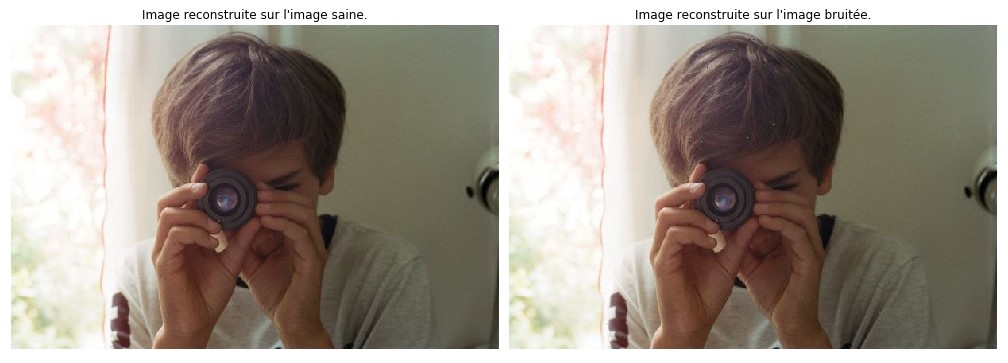
A part pour les cheveux, c'est concluant. On n'a apparemment pas trouvé de texture similaire en un nombre décent d'itérations. Les nombreux ConvergenceWarning en témoignent.  
Voyons si simplifier l'apparence générale de l'image permet de faire mieux.  
Cette tentative permet aussi de voir comment l'algorithme gère une plus grande quantité de bruit.

2790 patches à réécrire dans l'image bruitée.
19 ou 251 atomes selon le pas dans l'image bruitée.
Deux tentatives de reconstruction en cours.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


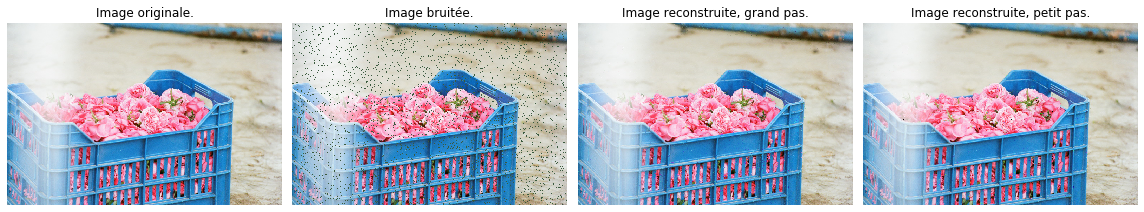

In [610]:
#///////////////////////////////////////////////////////////////////////////////////////////// <reconstruction complète 2> ////

# Une image plus bruitée, donc avec un peu plus de travail, mais plus simple en termes de textures.
# On retire les warnings dont on a bien conscience (ils sont assez lourds pour l'affichage.)

import warnings
import os
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

ros = readIm("src/ros.jpg")
# Ajout d'un bruit poivre.
noi = noise(ros,0.05)

# Patches bruités de l'image bruitée.
dicttoMend = qualifyPixPatch(noi,12,12)[1]
print("%d patches à réécrire dans l'image bruitée." %(len(dicttoMend)))

# CAS 4 : atomes de l'image bruitée, image complète.
# Un dictionnaire avec un grand pas.
dictbruiteSmall = qualifyPixPatch(noi,12,4)[0]
# Un dictionnaire avec un petit pas.
dictbruiteExp = qualifyPixPatch(noi,12,1)[0]
print("%d ou %d atomes selon le pas dans l'image bruitée." %(len(dictbruiteSmall),len(dictbruiteExp)))
print("Deux tentatives de reconstruction en cours.")

ims = ros.copy()
ime = ros.copy()

for pos, patch in dicttoMend.items():
    wbruiS,patchbS = approximatePatch(patch,dictbruiteSmall,alpha = 0.001)
    ims[pos[0]-12//2:pos[0]+12//2, pos[1]-12//2:pos[1]+12//2, :] = patchbS
    wbruiE,patchbE = approximatePatch(patch,dictbruiteExp,alpha = 0.001)
    ime[pos[0]-12//2:pos[0]+12//2, pos[1]-12//2:pos[1]+12//2, :] = patchbE
    
# Affichage.
reconstruct = plt.figure(figsize=(16,6))
ax0 = reconstruct.add_subplot(141)
ax0 = imshow(ros,"Image originale.")
ax1 = reconstruct.add_subplot(142)
ax1 = imshow(noi,"Image bruitée.")
ax2 = reconstruct.add_subplot(143)
ax2 = imshow(ims,"Image reconstruite, grand pas.")
ax3 = reconstruct.add_subplot(144)
ax3 = imshow(ime,"Image reconstruite, petit pas.")
plt.tight_layout()
plt.savefig("src/roses.jpg")
plt.show()

#//////////////////////////////////////////////////////////////////////////////////////////// </reconstruction complète 2> ////

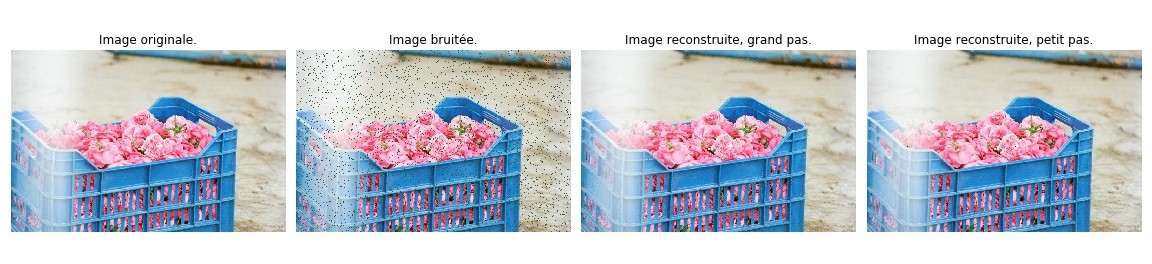
Le résultat est toujours satisfaisant.  
On a profité de la simplicité de la tâche pour essayer de confirmer nos intuitions sur la taille du dictionnaire appris : on aurait cru qu'un dictionnaire plus précis devrait donner une meilleure reconstruction.  
Mais ce n'est finalement pas le paramètre le plus important.
Preuve en images :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


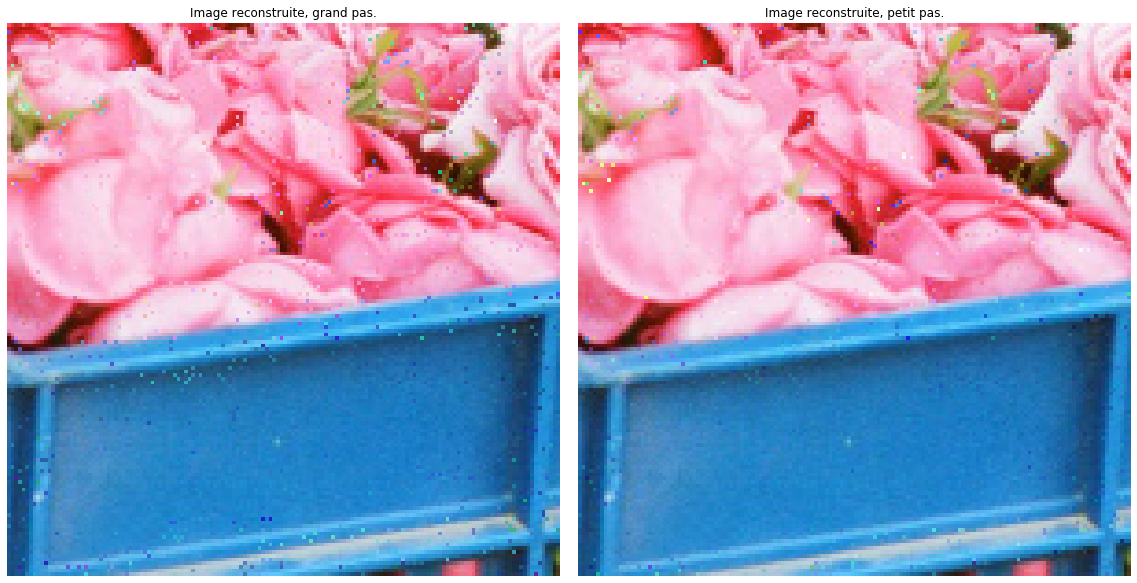

In [611]:
# Zoom.
reconstruct = plt.figure(figsize=(16,8))
ax2 = reconstruct.add_subplot(121)
ax2 = imshow(ims[250:400,250:400],"Image reconstruite, grand pas.")
ax3 = reconstruct.add_subplot(122)
ax3 = imshow(ime[250:400,250:400],"Image reconstruite, petit pas.")
plt.tight_layout()
plt.show()

On se rend compte que c'est surapprendre que d'utiliser tous les patches possibles, et perdre du temps sans impact réel sur le résultat. On modère donc la précision de ce point de vue, et on préfère modifier la taille du dictionnaire des patches bruités.
Si les patches bruités à corriger se superposent et ne forment plus un quadrillage, peut-être le résultat sera-t-il plus lisse ?

2791 ou 43395 patches à réécrire dans l'image bruitée, selon la précision.
25 atomes dans l'image bruitée.
Deux tentatives de reconstruction en cours.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


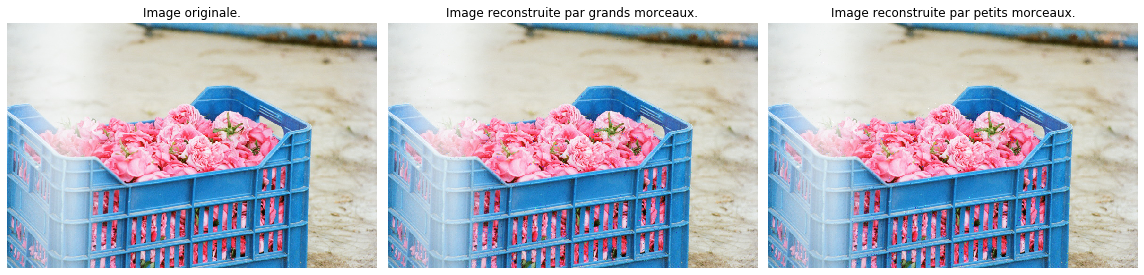

In [612]:
#///////////////////////////////////////////////////////////////////////////////////////////// <reconstruction complète 3> ////

# Une image plus bruitée, donc avec un peu plus de travail, mais plus simple en termes de textures.
# On retire les warnings dont on a bien conscience (ils sont assez lourds pour l'affichage.)
# Impact du pas de repérage pour les patches détériorés.

import warnings
import os
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

ros = readIm("src/ros.jpg")
# Ajout d'un bruit poivre.
noi = noise(ros,0.05)

# Patches bruités de l'image bruitée.
dicttoMendSmall = qualifyPixPatch(noi,12,12)[1]
dicttoMendExp = qualifyPixPatch(noi,12,3)[1]
print("%d ou %d patches à réécrire dans l'image bruitée, selon la précision." %(len(dicttoMendSmall),len(dicttoMendExp)))

# CAS 4 : atomes de l'image bruitée, image complète.
# Un dictionnaire avec un grand pas.
dictbruiteSmall = qualifyPixPatch(noi,12,4)[0]
print("%d atomes dans l'image bruitée." %(len(dictbruiteSmall)))
print("Deux tentatives de reconstruction en cours.")

ims = ros.copy()
ime = ros.copy()

for pos, patch in dicttoMendSmall.items():
    wbruiS,patchbS = approximatePatch(patch,dictbruiteSmall,alpha = 0.001)
    ims[pos[0]-12//2:pos[0]+12//2, pos[1]-12//2:pos[1]+12//2, :] = patchbS
for pos, patch in dicttoMendExp.items():
    wbruiE,patchbE = approximatePatch(patch,dictbruiteSmall,alpha = 0.001)
    ime[pos[0]-12//2:pos[0]+12//2, pos[1]-12//2:pos[1]+12//2, :] = patchbE
    
# Affichage.
reconstruct = plt.figure(figsize=(16,6))
ax0 = reconstruct.add_subplot(131)
ax0 = imshow(ros,"Image originale.")
ax1 = reconstruct.add_subplot(132)
ax1 = imshow(ims,"Image reconstruite par grands morceaux.")
ax2 = reconstruct.add_subplot(133)
ax2 = imshow(ime,"Image reconstruite par petits morceaux.")
plt.tight_layout()
plt.savefig("src/roses2.jpg")
plt.show()

#//////////////////////////////////////////////////////////////////////////////////////////// </reconstruction complète 3> ////

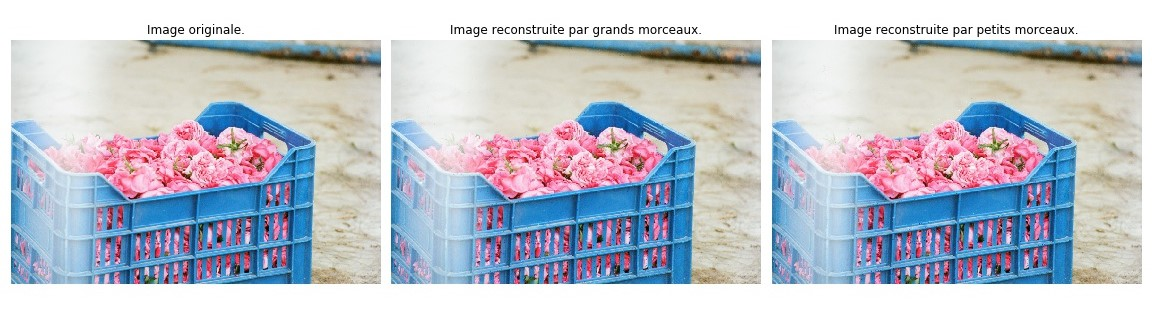
La petitesse du pas aide vraiment de peu sur le dictionnaire à reconstruire. La convergence ne se fait pas mieux (les pixels de couleur complètement incohérente correspondent initialement à des <code>ConvergenceWarning</code>) et il est impertinent d'utiliser tant de calculs supplémentaires pour une amélioration si minime (cf. <a href='#motdelafin'>fin de la section suivante</a> pour une explication).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


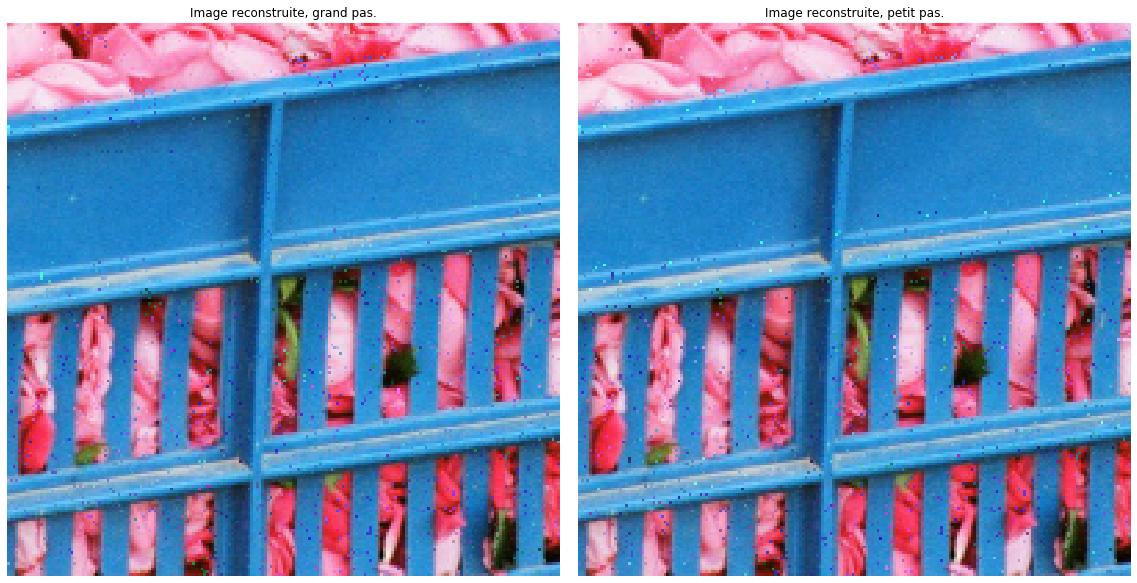

In [618]:
# Zoom.
reconstruct = plt.figure(figsize=(16,8))
ax2 = reconstruct.add_subplot(121)
ax2 = imshow(ims[300:500,300:500],"Image reconstruite, grand pas.")
ax3 = reconstruct.add_subplot(122)
ax3 = imshow(ime[300:500,300:500],"Image reconstruite, petit pas.")
plt.tight_layout()
plt.show()

### 2.3 Remplacement d'une structure supprimée

<a id='remplacer'></a>

La gestion du bruit par cette méthode n'est pas en adéquation avec la réalité. Réduire un bruit plafonné à 5% au grand maximum n'est vraiment pas un objectif intéressant ; au-delà, on s'est rendu compte qu'on manquait systématiquement de bases d'apprentissage.  
On va donc tenter des remplacements de parties entières de l'image, surlignées au préalable par l'utilisateur humain.  
On peut imaginer qu'il s'agit de zones bruitées.  
L'algorithme d'inpainting est capable de reconstruire ces parties dès lors que le remplissage se fait depuis les bords et en convergeant vers le centre.  
Nous n'avons pas exploré d'autres formes que le rectangle ; on ne traite donc aucun des problèmes liés à la frontière de remplissage concave. 

<a href='#gd'>Saut vers le remplissage basique</a>  
<a href='#spir'>Saut vers le remplissage en spirale</a>

In [33]:
#////////////////////////////////////////////////////////////////////////////////////////////////// <bases du remplissage> ////

def getBoundaryPatches(I,h):
    # Récupérer les patches voisins de la zone. Leurs pixels centraux
    # se trouveront sur les contours des zones manquantes.
    boundaryPatches = {}   
    # D'abord, lire les coordonnées des pixels manquants,
    # et en faire un un dictionnaire.
    coord = list(zip(*np.where(I[:,:,0] == -100)))
    dicoAbime = set(coord)
    # Pour chaque pixel bruité,
    for i, j in coord:
        # chercher parmi les quatre pixels voisins un candidat
        # sain qui ne dépasse pas les frontières de l'image.
        # S'il existe, extraire le patch centré sur ce pixel. 
        if (i-1 >= 0 and (i-1,j) not in dicoAbime) or \
           (j+1 < I.shape[1] and (i,j+1) not in dicoAbime) or \
           (i+1 < I.shape[0] and (i+1,j) not in dicoAbime) or \
           (j-1 >= 0 and (i, j-1) not in dicoAbime):
            boundaryPatches[(i, j)] = getPatch(I,i,j,h) 
    return boundaryPatches

def fillSimple(I, filling_step, h, patching_step, alpha = 0.01):
    # Passer au remplissage proprement dit.
    Ic = I.copy() 
    # Récupérer les patchs voisins de la région manquante,
    # de gauche à droite, de haut vers le bas.
    patches = getBoundaryPatches(Ic,h)
    trace = [] # contiendra la trace du traitement
    # Tant qu'il reste des patches à traiter,
    while len(patches) > 0:
        # sélectionner chaque filling_step'ième patch,
        listKeys = list(patches.keys())
        listKeysSliced = listKeys[1::filling_step]
        for pos in listKeysSliced:
            patch = patches[pos]
            # vérifier qu'il contient des pixels manquants,
            if np.sum(patch == -100) > 0:   
                # calculer combien et les approximer
                atoms, n = qualifyPixPatch(Ic,h,patching_step)
                w, newP = approximatePatch(patch,atoms,alpha=alpha)
                patch[:,:,:] = newP
                trace.append(pos)
        # Mise à jour des patches de contour.
        patches = getBoundaryPatches(Ic,h)
    return Ic, trace

#///////////////////////////////////////////////////////////////////////////////////////////////// </bases du remplissage> ////

#### 2.3.1 Remplissage de gauche à droite

<a id='gd'></a>
<a href='#motdelafin'>Avance rapide vers le mot de la fin.</a>  
L'algorithme le plus simple remplit la zone en suivant l'ordre d'un scan, de gauche à droite. C'est adapté lorsque les deux côtés de la structure supprimée "donnent" sur des fonds similaires : il n'y a alors pas de problème de transfert d'une texture à une autre. Ce ne sera pas le cas ailleurs.

In [ ]:
#//////////////////////////////////////////////////////////////////////////////////////////////////// <remplissage simple> ////

tfl = readIm("src/tfl.jpg")
tflGap = deleteRect(tfl,110,140,120,40)
tflRec,trace = fillSimple(tflGap, filling_step=15, h=20, patching_step=10, alpha=0.001)

# Affichage.
reconstruct = plt.figure(figsize=(15,5))
ax0 = reconstruct.add_subplot(131)
ax0 = imshow(tfl,"Image originale.")
ax1 = reconstruct.add_subplot(132)
ax1 = imshow(tflGap,title="Région manquante.")
ax2 = reconstruct.add_subplot(133)
ax2 = imshow(tflRec,title="Région reconstruite.")
plt.tight_layout()
plt.savefig("src/tflrec.jpg")
plt.show()

#/////////////////////////////////////////////////////////////////////////////////////////////////// </remplissage simple> ////

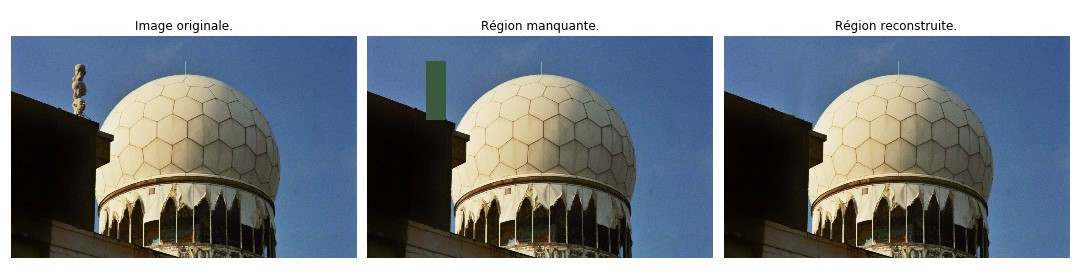
La statue se détache sur le ciel. Il est donc possible de remplir simplement de gauche à droite avec un résultat assez cohérent.  
On a perdu un peu du grain du ciel qu'on devait au type de pellicule. Ce flou est classique en inpainting, et c'est un problème que la source [3] fournie dans l'énoncé tentait justement d'adresser (nous n'avons rien programmé en ce sens).

Le contour du toit du bâtiment a perdu en lisseté et la frontière entre pierre et ciel présente un effet de fausses couleurs du fait de la conversion RGB/HSV.

Pour voir si l'on peut faire mieux, on essaie des patches de plus grande taille pour créer les combinaisons, avec l'espoir de conserver un peu mieux les textures.

In [ ]:
#///////////////////////////////////////////////////////////////////////////////////////// <remplissage simple amélioré ?> ////

tfl = readIm("src/tfl.jpg")
tflGap = deleteRect(tfl,110,140,120,40)
tflRec,trace = fillSimple(tflGap, filling_step=15, h=40, patching_step=10, alpha=0.001)

# Affichage.
reconstruct = plt.figure(figsize=(15,5))
ax0 = reconstruct.add_subplot(131)
ax0 = imshow(tfl,"Image originale.")
ax1 = reconstruct.add_subplot(132)
ax1 = imshow(tflGap,title="Région manquante.")
ax2 = reconstruct.add_subplot(133)
ax2 = imshow(tflRec,title="Région reconstruite.")
plt.tight_layout()
plt.savefig("src/tflrec2.jpg")
plt.show()

#//////////////////////////////////////////////////////////////////////////////////////// </remplissage simple amélioré ?> ////

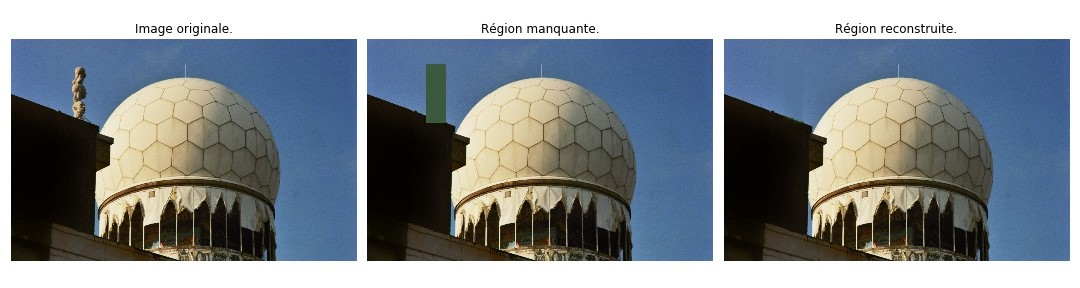
Ce n'est pas intéressant. Le calcul est long, et les bordures du rectangle effacé sont encore plus visibles.

La source [3] proposait un remplissage sur des images de texte, voyons comment on s'en sort :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


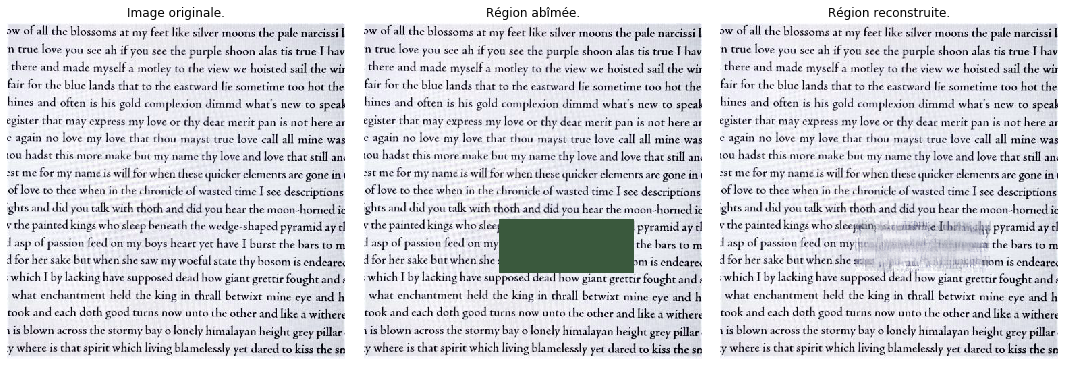

In [34]:
#///////////////////////////////////////////////////////////////////////////////////////////////// <remplissage sur texte> ////

tx = readIm("src/txt.jpg")
txtGap = deleteRect(tx,330,300,80,200)
txtRec,trace = fillSimple(txtGap, filling_step=20, h=20, patching_step=10, alpha=0.001)

# Affichage.
reconstruct = plt.figure(figsize=(15,5))
ax0 = reconstruct.add_subplot(131)
ax0 = imshow(tx,title="Image originale.")
ax1 = reconstruct.add_subplot(132)
ax1 = imshow(txtGap,title="Région abîmée.")
ax2 = reconstruct.add_subplot(133)
ax2 = imshow(txtRec,title="Région reconstruite.")
plt.tight_layout()
plt.savefig("src/txtrec.jpg")
plt.show()

#//////////////////////////////////////////////////////////////////////////////////////////////// </remplissage sur texte> ////

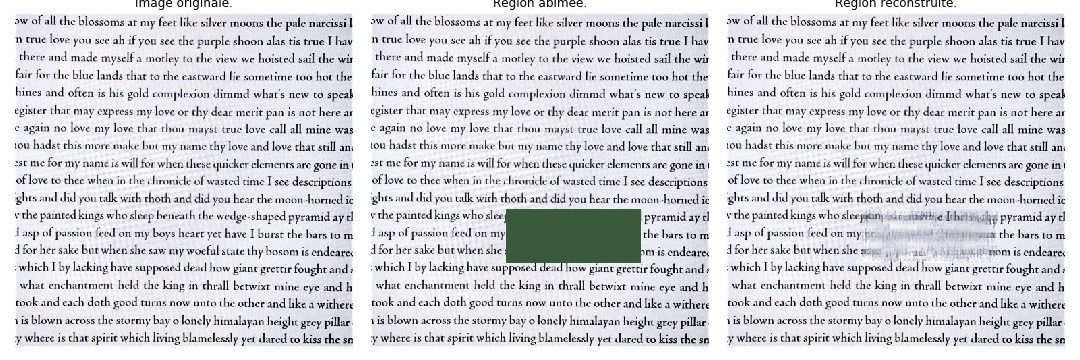On est loin de la qualité de résultat de la source [3], ce qui explique bien leur volonté de développer un algorithme plus performant. Le flou ne permet pas du tout de comprendre ce qui est écrit.  
On note quand même qu'avec les paramètres adéquats, l'algorithme a compris qu'il s'agissait de remplir trois lignes. Il rend une texture crédible même si le "texte," généré, lui, est illisible. 

<a id='motdelafin'></a>
***Le mot de la fin***  
Pour le remplissage, il est important de trouver un équilibre entre la qualité des textures (le flou persistera quoi qu'il arrive) et celle des contours.  
Intuitivement, les contours seraient améliorés, plus lisses, plus crédibles, en passant par des patches plus petits.  
Les textures par contre seront moins cohérentes. Si c'est la priorité, mieux vaut donc apprendre et remplir des régions plus larges à chaque itération (et donc causer du tort aux contours).

Tout l'art de l'inpainting réside dans cet équilibre que nous ne maîtrisons pas encore.

Un autre problème est celui de l'"overshoot" qui est lié à l'échappée d'une texture hors de ses limites visuelles attendues, jusqu'à empiéter sur une zone où on en attend une autre. C'est en fait systématique (observer la limite du toit sur <code>tflrec.jpg</code> : elle dépasse légèrement la ligne droite), mais plus évident lorsque la région abîmée se situe dans une zone complexe.

#### 2.3.2 Remplissage en spirale

<a id='spir'></a>
Ce qui s'est déplacé de gauche à droite dans le cas précédent s'appelle le _front de remplissage_. Comme on l'a vu, le résultat était probant pour une situation comme celles-là, où les patches à approximer sont bien entourés par la "matière" adéquate.  
Lorsque l'environnement n'est pas égal de tous les côtés, la matière qui borde la région manquante à gauche risque de "déteindre" sur la partie droite au fur et à mesure que le remplissage s'étend. C'est l'_overshoot_.
Changer la forme du front de remplissage permet de limiter cet effet.

Ici, nous proposons un remplissage en spirale, avec l'ambition que chaque _overshoot_ de la gauche vers la droite soit immédiatement compensé par un _overshoot_ de la droite vers la gauche (et de même de bas en haut).
Est-ce utile ?

In [69]:
#//////////////////////////////////////////////////////////////////////////////////////////////// <remplissage en spirale> ////

# Le code pour rappel, avec des modifications mineures (aurait été factorisable avec fillSimple).
from scipy import ndimage as ndi
from tqdm import tqdm

def showTrace(I,trace,title=None,size=500):
    # Afficher la trace pour comprendre le remplissage en spirale.
    Ic = np.copy(I)
    mask = (Ic == -100) 
    Ic[mask] = -1
    # Normalisation.
    Ic = normalizeColorImage(Ic,kmin=0,kmax=1,Imin=-1,Imax=1)
    Ic = hsv_to_rgb(Ic) # conversion HSV to RGB
    plt.figure(figsize=(size//80, size//80))
    c = np.array(trace)
    sc = plt.scatter(c[:,1],c[:,0],c=range(len(c)),s=20,cmap='pink')
    plt.imshow(Ic)
    plt.colorbar(sc,fraction=0.025)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

def spiral(A):
    # Récupère en spirale des éléments de la matrice A.
    A = np.array(A)
    out = []
    while(A.size):
        out.append(A[0])        # Première ligne.
        A = A[1:].T[::-1]       # Retirer et tourner dans le sens inverse des aiguilles d'une montre.
    return np.concatenate(out)

def getSpiralBoundaryPatches(I,h):
    # Récupération des patches en spirale.
    # Leurs pixels centraux se trouveront sur les contours des zones manquantes.
    boundaryPatches = {} 
    Ic = I.copy()
    mask = (Ic != -100)
    Ic[mask] = 0
    Ic[np.logical_not(mask)] = 1
    rect, nrect = ndi.label(Ic[:,:,0])
    for r in range(1,nrect+1):
        indices = np.argwhere(rect==r)
        xMask,yMask = indices[:,0], indices[:,1]
        lenx = np.max(xMask)-np.min(xMask)+1
        leny = np.max(yMask)-np.min(yMask)+1
        x = (xMask).reshape(lenx,leny)
        y = (yMask).reshape(lenx,leny)
        xSpiral = spiral(y)
        ySpiral = spiral(x)
        # Contient des coordonées en spirale d'un rectangle.
        coord = list(zip(ySpiral,xSpiral))#[::-1]
        dicoCoord= set(coord)
        # La suite est similaire à getBoundaryPatches.
        for i, j in coord:
            if (i-1 >= 0 and (i-1, j) not in dicoCoord) or \
               (j+1 < I.shape[1] and (i, j+1) not in dicoCoord) or \
               (i+1 < I.shape[0] and (i+1, j) not in dicoCoord) or \
               (j-1 >= 0 and (i, j-1) not in dicoCoord):
                boundaryPatches[(i,j)] = getPatch(I,i,j,h)
    return boundaryPatches

def fillSpiral(I, filling_step, h, patching_step, alpha = 0.01): 
    # Presque rien ne change...
    Ic = I.copy() 
    patches = getSpiralBoundaryPatches(Ic, h)
    trace = [] # contiendra la trace du traitement
    # Pour la barre de traitement, 
    # un outil de debug très pratique
    totMissing = (Ic==-100).sum() // 3
    with tqdm(total = totMissing) as pbar:
        # Tant qu'il ne reste plus de patch à traiter,
        while totMissing > 0: # 
            # effectuer toujours les mêmes opérations
            listKeys = list(patches.keys())
            listKeysSliced = listKeys[1::filling_step]
            for pos in listKeysSliced:
                patch = patches[pos]
                if np.sum(patch == -100) > 0:   
                    atoms, n = qualifyPixPatch(Ic, h, patching_step)
                    w, newP = approximatePatch(patch, atoms, alpha = alpha)
                    patch[:, :, :] = newP
                    trace.append(pos)
                # Pour la barre de traitement.
                missing = (Ic==-100).sum() // 3
                pbar.update(totMissing - missing)
                totMissing = missing        
            # Mise à jour de tous les patches centrés sur les contours de la région manquante.
            patches = getSpiralBoundaryPatches(Ic,h)
    return Ic, trace

#//////////////////////////////////////////////////////////////////////////////////////////////// <remplissage en spirale> ////

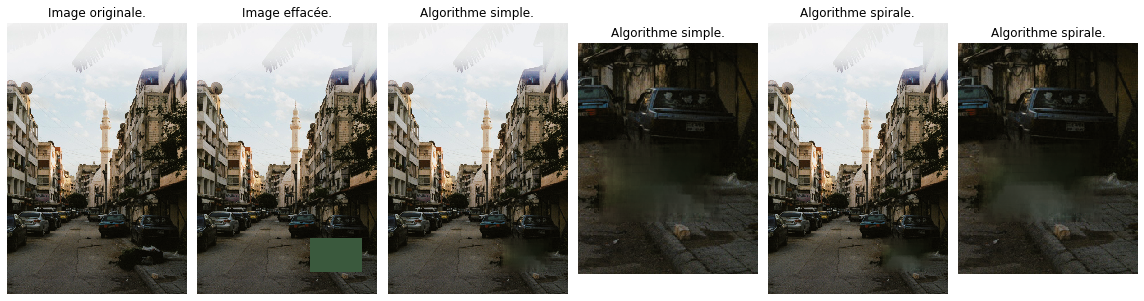

In [77]:
#////////////////////////////////////////////////////////////////////////////////////////// <comparaison des remplissages> ////

# Ce soir, nous nettoyons la rue.

minn = readIm("src/min.jpg")
minGap = deleteRect(min,670,400,100,150)
minRecSimple,traceSimple = fillSimple(minGap, filling_step=15, h=20, patching_step=10, alpha=0.001)
minRecSpirale,traceSpirale = fillSpiral(minGap, filling_step=15, h=20, patching_step=10, alpha=0.001)

# Affichage.
reconstruct = plt.figure(figsize=(16,12))
ax0 = reconstruct.add_subplot(161)
ax0 = imshow(minn,title="Image originale.")
ax1 = reconstruct.add_subplot(162)
ax1 = imshow(minGap,title="Image effacée.")
ax2 = reconstruct.add_subplot(163)
ax2 = imshow(minRecSimple,title="Algorithme simple.")
ax3 = reconstruct.add_subplot(164)
ax3 = imshow(minRecSimple[500:,300:],title="Algorithme simple.")
ax4 = reconstruct.add_subplot(165)
ax4 = imshow(minRecSpirale,title="Algorithme spirale.")
ax5 = reconstruct.add_subplot(166)
ax5 = imshow(minRecSpirale[500:,300:],title="Algorithme spirale.")
plt.tight_layout()
plt.savefig("src/minspirale.jpg")
plt.show()

#///////////////////////////////////////////////////////////////////////////////////////// </comparaison des remplissages> ////

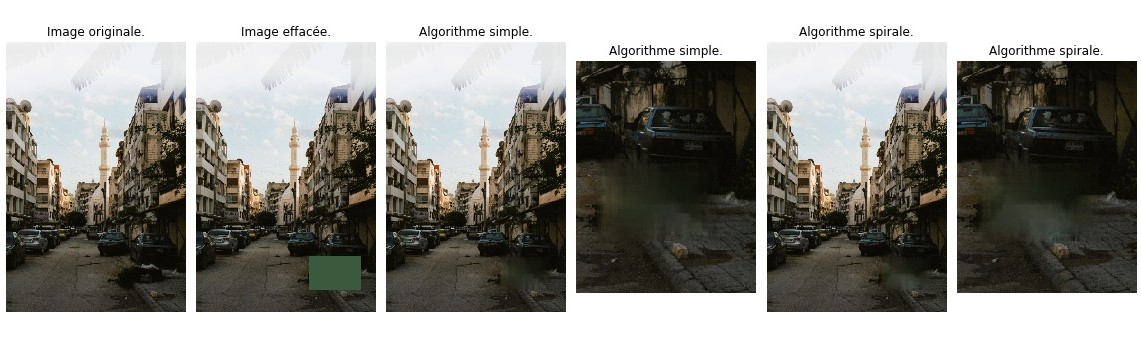
On constate bien que le remplissage se fait beaucoup mieux avec l'un qu'avec l'autre. La poubelle est sortie, mais à sa place désormais.

La spirale laisse quand même des traces importantes, mais c'est mieux qu'un flou quasiment uniforme sur la région manquante.

Encore un essai.

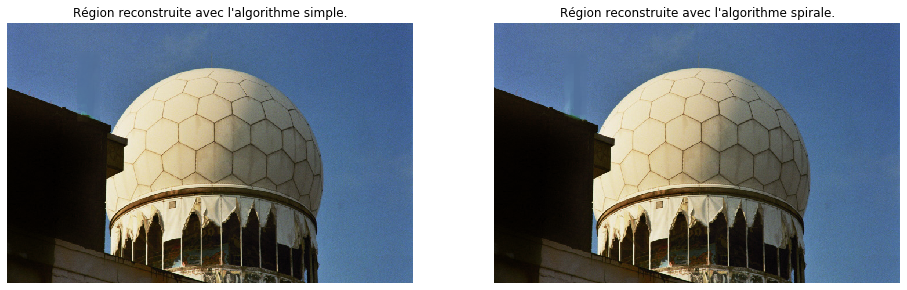

In [79]:
# Affichage.
reconstruct = plt.figure(figsize=(16,8))
ax0 = reconstruct.add_subplot(121)
ax0 = imshow(tflRecSimple,title="Région reconstruite avec l'algorithme simple.")
ax1 = reconstruct.add_subplot(122)
ax1 = imshow(tflRecSpirale,title="Région reconstruite avec l'algorithme spirale.")
plt.savefig("src/tflspirale.jpg")

En somme, la spirale ne rend pas un résultat uniforme. On gagne en qualité de texture, mais l'on fait apparaître des contours internes dans la région à réparer. C'est à voir en fonction du contexte.

Un affichage de la trace pour mieux comprendre :

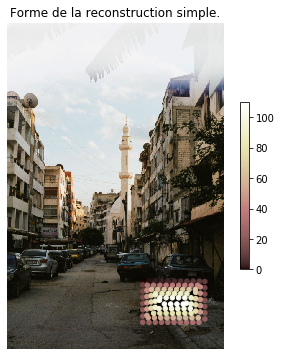

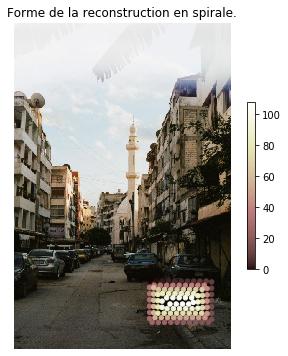

In [81]:
showTrace(minn,traceSimple,title="Forme de la reconstruction simple.")
showTrace(minn,traceSpirale,title="Forme de la reconstruction en spirale.")

Ce n'est pas le meilleur exemple pour constater la différence, mais elle est là (!)

#### 2.3.3 Extra

Une fonction dont nous avons discuté avec Ariana Carnielli. C'est son idée.
Il s'agit à proprement parler d'une heuristique qui ne dépend plus d'une forme fixée pour le front de remplissage,
mais qui tente de trouver des patches prioritaires, à remplir en premier en fonction de leur écart-type.

In [ ]:
#////////////////////////////////////////////////////////////////////////////////////////////////////// <un dernier essai> ////

def simpleScore(patch):
    # Quantité de complétion d'un patch.
    # Ce qu'on utilisait au départ.
    return np.sum(patch!=-100)

def stdScore(patch, alpha=0.5):
    # Ecart-type des pixels exprimés vs. abîmés sur un patch.
    # C'est plus intelligent.
    filled = np.sum(patch != -100)/patch.size
    mask = patch[:,:,0] != -100
    std = 0
    for i in range(3):
        std += patch[:,:,i][mask].std()
    return filled+alpha*(std/3)

def fillCriteria(I,h,step,alpha = 0.01,score=stdScore,prc = 0.1):
    Ic = I.copy() 
    boundary = getBoundaryPatches(Ic,h)    
    trace = []
    # Barre de traitement.
    tot_missing = (Ic==-100).sum() // 3
    with tqdm(total = tot_missing) as pbar:
        # Tant qu'il ne reste plus de patches à traiter,
        while len(boundary) > 0:
            # Choisir le meilleur patch à traiter selon la fonction de score.
            scores = {k: score(p) for k, p in boundary.items()}
            # Calculer le taux de "tolérance",
            max_score = max(scores.values())
            tol_score = max_score * (1 - prc)
            # trouver les patches respectant ce score "tolérable"
            l = [k for k, s in scores.items() if s >= tol_score]
            # et choisir aléatoirement un patch parmi les meilleurs proposés
            best_pos = np.random.choice(len(l)) 
            best_pos = l[best_pos]
            best_patch = boundary[best_pos]
            # Garder la trace du choix
            trace.append(best_pos)
            # et approximer les pixels manquants pour le patch choisi
            atoms, n = qualifyPixPatch(Ic, h, step)
            w, newP = approximatePatch(best_patch, atoms, alpha = alpha)
            best_patch[:, :, :] = newP
            # Mise à jour de l'ensemble.
            boundary = getBoundaryPatches(Ic,h)
            # Barre de traitement.
            missing = (Ic==-100).sum() // 3
            pbar.update(tot_missing - missing)
            tot_missing = missing
    return Ic, trace

# On sait qu'elle a obtenu de très bons résultats.

#////////////////////////////////////////////////////////////////////////////////////////////////////// <un dernier essai> ////

On souhaite montrer les différences de traces, qu'on a essayées : de gauche à droite, le cas basique, la version d'Ariana, puis notre spirale.

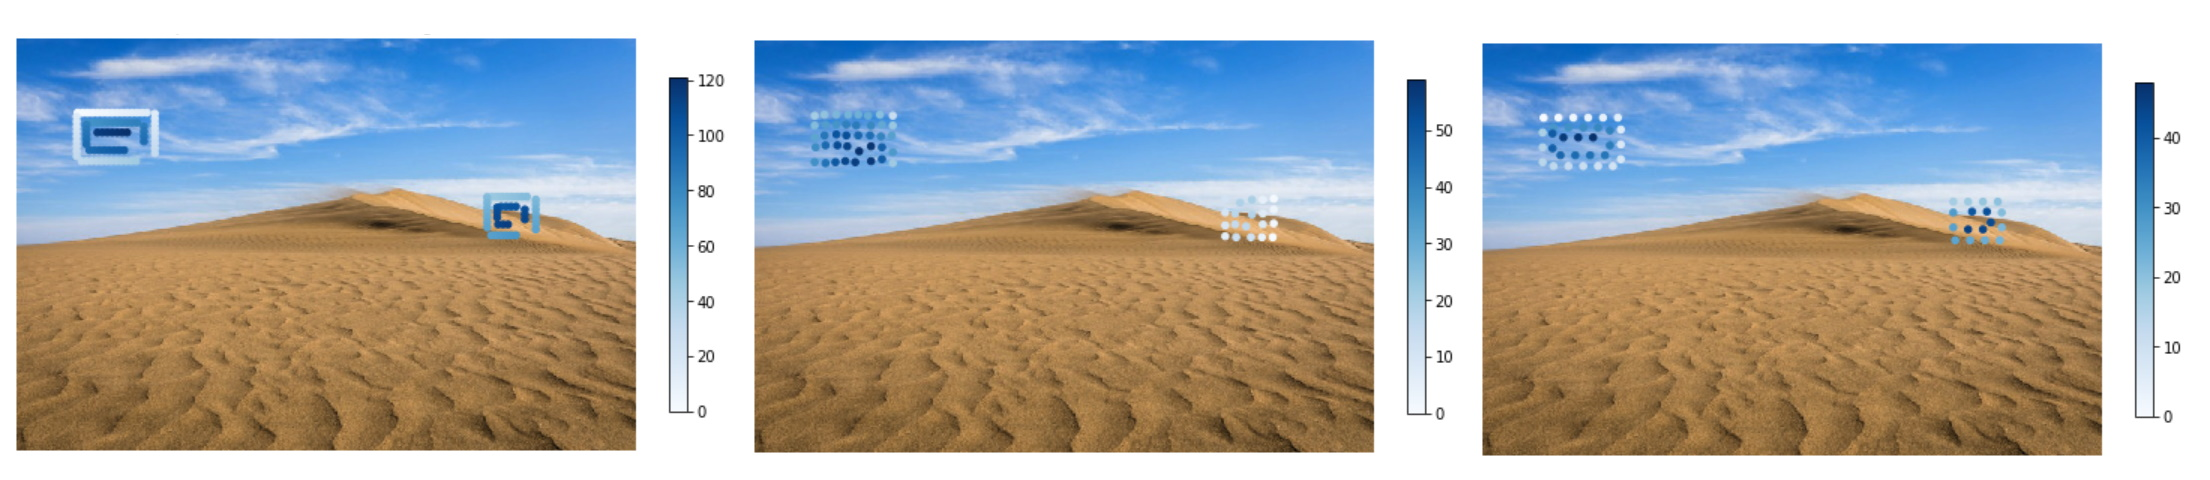

C'était la dernière expérience de cette campagne.

### 2.4 Idées supplémentaires 

Nos fonctions ne sont pas optimisées. C'est à faire.  
Pour les images dont il manque une trop grande partie, une bonne idée serait d'apprendre l'approximation sur une base de données similaires. Essayer de la régénérer à partir de l'image abîmée serait risqué s'il manque trop d'information.
Ce pourrait être une extension intéressante de ce projet.

Source [3] : https://www.irisa.fr/vista/Papers/2004_ip_criminisi.pdf  
(c) Images copyrightées L. S.